# HEOM 1c: Spin-Bath model (Underdamped Case)

## Introduction

The HEOM method solves the dynamics and steady state of a system and its environment, the latter of which is encoded in a set of auxiliary density matrices.

In this example we show the evolution of a single two-level system in contact with a single Bosonic environment.  The properties of the system are encoded in Hamiltonian, and a coupling operator which describes how it is coupled to the environment.

The Bosonic environment is implicitly assumed to obey a particular Hamiltonian ([see paper](https://arxiv.org/abs/2010.10806)), the parameters of which are encoded in the spectral density, and subsequently the free-bath correlation functions.

In the example below we show how to model the underdamped Brownian motion Spectral Density.

Note that in the following, we set $\hbar = k_\mathrm{B} = 1$.

###  Brownian motion (underdamped) spectral density
The underdamped spectral density is:

$$J_U = \frac{\alpha^2 \Gamma \omega}{(\omega_c^2 - \omega^2)^2 + \Gamma^2 \omega^2)}.$$

Here $\alpha$  scales the coupling strength, $\Gamma$ is the cut-off frequency, and $\omega_c$ defines a resonance frequency.  With the HEOM we must use an exponential decomposition:

The Matsubara decomposition of this spectral density is, in real and imaginary parts:



\begin{equation*}
    c_k^R = \begin{cases}
               \alpha^2 \coth(\beta( \Omega + i\Gamma/2)/2)/4\Omega & k = 0\\
               \alpha^2 \coth(\beta( \Omega - i\Gamma/2)/2)/4\Omega & k = 0\\
              -2\alpha^2\Gamma/\beta \frac{\epsilon_k }{((\Omega + i\Gamma/2)^2 + \epsilon_k^2)(\Omega - i\Gamma/2)^2 + \epsilon_k^2)}      & k \geq 1\\
           \end{cases}
\end{equation*}

\begin{equation*}
    \nu_k^R = \begin{cases}
               -i\Omega  + \Gamma/2, i\Omega  +\Gamma/2,             & k = 0\\
               {2 \pi k} / {\beta }  & k \geq 1\\
           \end{cases}
\end{equation*}




\begin{equation*}
    c_k^I = \begin{cases}
               i\alpha^2 /4\Omega & k = 0\\
                -i\alpha^2 /4\Omega & k = 0\\
           \end{cases}
\end{equation*}

\begin{equation*}
    \nu_k^I = \begin{cases}
               i\Omega  + \Gamma/2, -i\Omega  + \Gamma/2,             & k = 0\\
           \end{cases}
\end{equation*}

Note that in the above, and the following, we set $\hbar = k_\mathrm{B} = 1$.

## Setup

In [1]:
import contextlib
import time

import numpy as np
from matplotlib import pyplot as plt

from qutip import (about, basis, brmesolve, destroy, expect, qeye,
                   sigmax, sigmaz, tensor)
from qutip.core.environment import (
    ExponentialBosonicEnvironment, UnderDampedEnvironment
)
from qutip.solver.heom import HEOMSolver

%matplotlib inline

## Helper functions

Let's define some helper functions for calculating correlation function expansions, plotting results and timing how long operations take:

In [2]:
def cot(x):
    """ Vectorized cotangent of x. """
    return 1.0 / np.tan(x)

In [3]:
def coth(x):
    """ Vectorized hyperbolic cotangent of x. """
    return 1.0 / np.tanh(x)

In [4]:
def underdamped_matsubara_params(lam, gamma, T, nk):
    """ Calculation of the real and imaginary expansions of the
        underdamped correlation functions.
    """
    Om = np.sqrt(w0**2 - (gamma / 2)**2)
    Gamma = gamma / 2.0
    beta = 1.0 / T

    ckAR = [
        (lam**2 / (4*Om)) * coth(beta * (Om + 1.0j * Gamma) / 2),
        (lam**2 / (4*Om)) * coth(beta * (Om - 1.0j * Gamma) / 2),
    ]
    ckAR.extend(
        (-2 * lam**2 * gamma / beta) * (2 * np.pi * k / beta) /
        (((Om + 1.0j * Gamma)**2 + (2 * np.pi * k / beta)**2) *
         ((Om - 1.0j * Gamma)**2 + (2 * np.pi * k / beta)**2)) + 0.j
        for k in range(1, nk + 1)
    )
    vkAR = [
        -1.0j * Om + Gamma,
        1.0j * Om + Gamma,
    ]
    vkAR.extend(2 * np.pi * k * T + 0.0j for k in range(1, nk + 1))

    factor = 1.0 / 4

    ckAI = [
        -factor * lam**2 * 1.0j / Om,
        factor * lam**2 * 1.0j / Om,
    ]
    vkAI = [
        -(-1.0j * Om - Gamma),
        -(1.0j * Om - Gamma),
    ]

    return ckAR, vkAR, ckAI, vkAI

In [5]:
def plot_result_expectations(plots, axes=None):
    """ Plot the expectation values of operators as functions of time.

        Each plot in plots consists of: (solver_result, measurement_operation,
        color, label).
    """
    if axes is None:
        fig, axes = plt.subplots(1, 1, sharex=True, figsize=(8, 8))
        fig_created = True
    else:
        fig = None
        fig_created = False

    # add kw arguments to each plot if missing
    plots = [p if len(p) == 5 else p + ({},) for p in plots]
    for result, m_op, color, label, kw in plots:
        exp = np.real(expect(result.states, m_op))
        kw.setdefault("linewidth", 2)
        axes.plot(result.times, exp, color, label=label, **kw)

    if fig_created:
        axes.legend(loc=0, fontsize=12)
        axes.set_xlabel("t", fontsize=28)

    return fig

In [6]:
@contextlib.contextmanager
def timer(label):
    """ Simple utility for timing functions:

        with timer("name"):
            ... code to time ...
    """
    start = time.time()
    yield
    end = time.time()
    print(f"{label}: {end - start}")

In [7]:
# Solver options:

options = {
    "nsteps": 15000,
    "store_states": True,
    "rtol": 1e-14,
    "atol": 1e-14,
    "method": "vern9",
    "progress_bar": "enhanced",
}

## System and bath definition

And let us set up the system Hamiltonian, bath and system measurement operators:

In [8]:
# Defining the system Hamiltonian
eps = 0.5  # Energy of the 2-level system.
Del = 1.0  # Tunnelling term
Hsys = 0.5 * eps * sigmaz() + 0.5 * Del * sigmax()

In [9]:
# Initial state of the system.
rho0 = basis(2, 0) * basis(2, 0).dag()

In [10]:
# System-bath coupling (underdamed spectral density)
Q = sigmaz()  # coupling operator

# Bath properties:
gamma = 0.1  # cut off frequency
lam = 0.5    # coupling strength
w0 = 1.0     # resonance frequency
T = 1.0
beta = 1.0 / T

# HEOM parameters:

# number of exponents to retain in the Matsubara expansion of the
# bath correlation function:
Nk = 2

# Number of levels of the hierarchy to retain:
NC = 10

# Times to solve for:
tlist = np.linspace(0, 50, 1000)

In [11]:
# Define some operators with which we will measure the system
# 1,1 element of density matrix - corresonding to groundstate
P11p = basis(2, 0) * basis(2, 0).dag()
P22p = basis(2, 1) * basis(2, 1).dag()
# 1,2 element of density matrix  - corresonding to coherence
P12p = basis(2, 0) * basis(2, 1).dag()

### First let us look at what the underdamped spectral density looks like:

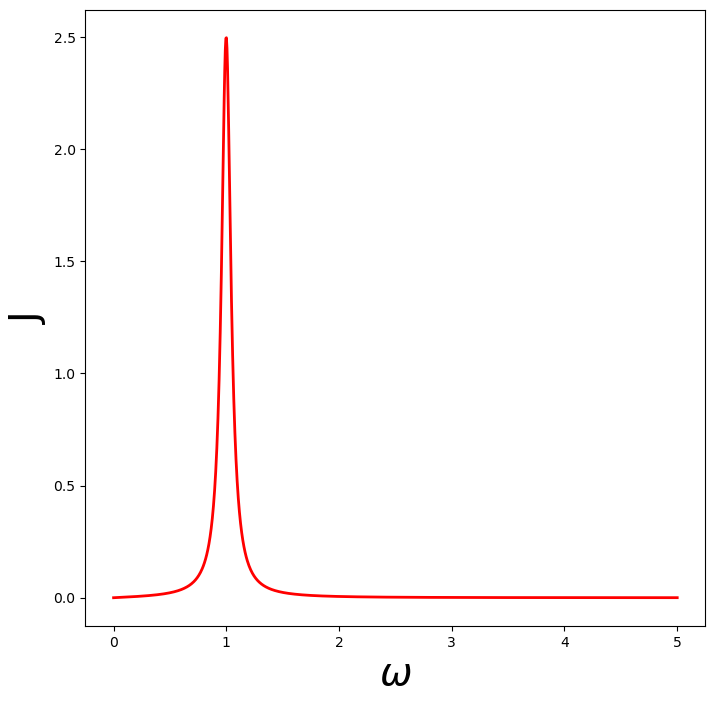

In [12]:
def plot_spectral_density():
    """ Plot the underdamped spectral density """
    w = np.linspace(0, 5, 1000)
    J = lam**2 * gamma * w / ((w0**2 - w**2)**2 + (gamma**2) * (w**2))

    fig, axes = plt.subplots(1, 1, sharex=True, figsize=(8, 8))
    axes.plot(w, J, 'r', linewidth=2)
    axes.set_xlabel(r'$\omega$', fontsize=28)
    axes.set_ylabel(r'J', fontsize=28)


plot_spectral_density()

The correlation functions are now very oscillatory, because of the Lorentzian peak in the spectral density.

### So next, let us plot the correlation functions themselves:

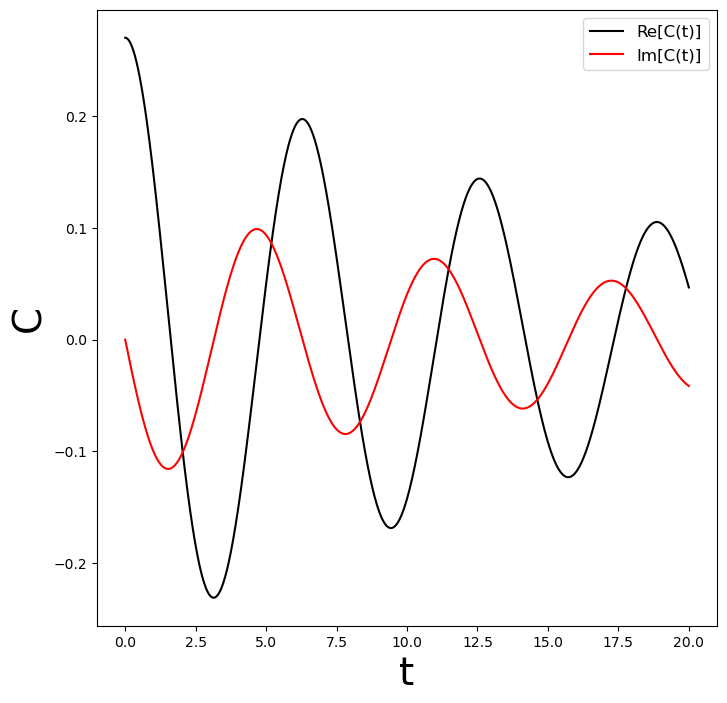

In [13]:
def Mk(t, k, gamma, w0, beta):
    """ Calculate the Matsubara terms for a given t and k. """
    Om = np.sqrt(w0**2 - (gamma / 2)**2)
    Gamma = gamma / 2.0
    ek = 2 * np.pi * k / beta

    return (
        (-2 * lam**2 * gamma / beta) * ek * np.exp(-ek * np.abs(t))
        / (((Om + 1.0j * Gamma)**2 + ek**2) * ((Om - 1.0j * Gamma)**2 + ek**2))
    )


def c(t, Nk, lam, gamma, w0, beta):
    """ Calculate the correlation function for a vector of times, t. """
    Om = np.sqrt(w0**2 - (gamma / 2)**2)
    Gamma = gamma / 2.0

    Cr = (
        coth(beta * (Om + 1.0j * Gamma) / 2) * np.exp(1.0j * Om * t)
        + coth(beta * (Om - 1.0j * Gamma) / 2) * np.exp(-1.0j * Om * t)
    )

    Ci = np.exp(-1.0j * Om * t) - np.exp(1.0j * Om * t)

    return (
        (lam**2 / (4 * Om)) * np.exp(-Gamma * np.abs(t)) * (Cr + Ci) +
        np.sum([
            Mk(t, k, gamma=gamma, w0=w0, beta=beta)
            for k in range(1, Nk + 1)
        ], 0)
    )


def plot_correlation_function():
    """ Plot the underdamped correlation function. """
    t = np.linspace(0, 20, 1000)
    corr = c(t, Nk=3, lam=lam, gamma=gamma, w0=w0, beta=beta)

    fig, axes = plt.subplots(1, 1, sharex=True, figsize=(8, 8))
    axes.plot(t, np.real(corr), '-', color="black", label="Re[C(t)]")
    axes.plot(t, np.imag(corr), '-', color="red", label="Im[C(t)]")
    axes.set_xlabel(r't', fontsize=28)
    axes.set_ylabel(r'C', fontsize=28)
    axes.legend(loc=0, fontsize=12)


plot_correlation_function()

It is useful to look at what the Matsubara contributions do to this spectral density. We see that they modify the real part around $t=0$:

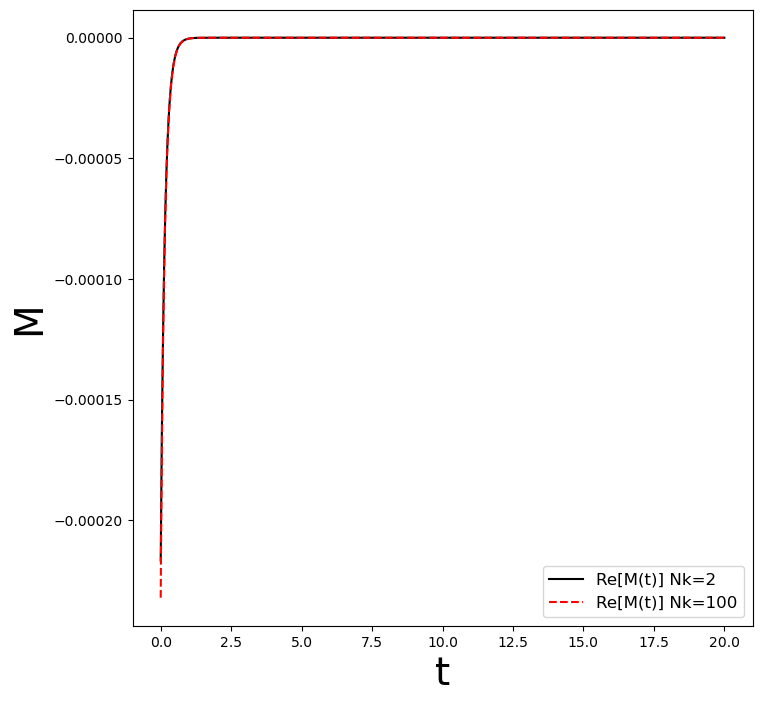

In [14]:
def plot_matsubara_correlation_function_contributions():
    """ Plot the underdamped correlation function. """
    t = np.linspace(0, 20, 1000)

    M_Nk2 = np.sum(
        [Mk(t, k, gamma=gamma, w0=w0, beta=beta) for k in range(1, 2 + 1)], 0
    )

    M_Nk100 = np.sum(
        [Mk(t, k, gamma=gamma, w0=w0, beta=beta) for k in range(1, 100 + 1)], 0
    )

    fig, axes = plt.subplots(1, 1, sharex=True, figsize=(8, 8))
    axes.plot(t, np.real(M_Nk2), '-', color="black", label="Re[M(t)] Nk=2")
    axes.plot(t, np.real(M_Nk100), '--', color="red", label="Re[M(t)] Nk=100")
    axes.set_xlabel(r't', fontsize=28)
    axes.set_ylabel(r'M', fontsize=28)
    axes.legend(loc=0, fontsize=12)


plot_matsubara_correlation_function_contributions()

## Solving for the dynamics as a function of time

Next we calculate the exponents using the Matsubara decompositions. Here we split them into real and imaginary parts.

The HEOM code will optimize these, and reduce the number of exponents when real and imaginary parts have the same exponent. This is clearly the case for the first term in the vkAI and vkAR lists.

In [15]:
ckAR, vkAR, ckAI, vkAI = underdamped_matsubara_params(
    lam=lam, gamma=gamma, T=T, nk=Nk,
)

Having created the lists which specify the bath correlation functions, we create an `ExponentialBosonicEnvironment` from them and pass the bath to the `HEOMSolver` class.

The solver constructs the "right hand side" (RHS) determinining how the system and auxiliary density operators evolve in time. This can then be used to solve for dynamics or steady-state.

Below we create the bath and solver and then solve for the dynamics by calling `.run(rho0, tlist)`.

In [16]:
with timer("RHS construction time"):
    env = ExponentialBosonicEnvironment(ckAR, vkAR, ckAI, vkAI)
    HEOMMats = HEOMSolver(Hsys, (env, Q), NC, options=options)

with timer("ODE solver time"):
    resultMats = HEOMMats.run(rho0, tlist)

RHS construction time: 0.03680539131164551
 [          0%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [          0%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          0%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          0%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:01

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:01

 [          1%           ] Elapsed 0.02s / Remaining 00:00:00:01

 [          1%           ] Elapsed 0.02s / Remaining 00:00:00:01

 [          1%           ] Elapsed 0.02s / Remaining 00:00:00:01

 [          1%           ] Elapsed 0.02s / Remaining 00:00:00:01

 [          1%           ] Elapsed 0.02s / Remaining 00:00:00:02

 [          1%           ] Elapsed 0.02s / Remaining 00:00:00:02

 [          1%           ] Elapsed 0.02s / Remaining 00:00:00:02

 [          1%           ] Elapsed 0.03s / Remaining 00:00:00:02

 [          2%           ] Elapsed 0.03s / Remaining 00:00:00:01

 [          2%           ] Elapsed 0.04s / Remaining 00:00:00:01

 [          2%           ] Elapsed 0.04s / Remaining 00:00:00:01

 [          2%           ] Elapsed 0.04s / Remaining 00:00:00:02

 [          2%           ] Elapsed 0.04s / Remaining 00:00:00:02

 [          2%           ] Elapsed 0.05s / Remaining 00:00:00:02

 [          2%           ] Elapsed 0.05s / Remaining 00:00:00:02

 [          2%           ] Elapsed 0.05s / Remaining 00:00:00:02

 [          2%           ] Elapsed 0.06s / Remaining 00:00:00:02

 [          2%           ] Elapsed 0.06s / Remaining 00:00:00:02

 [*         3%           ] Elapsed 0.06s / Remaining 00:00:00:01

 [*         3%           ] Elapsed 0.07s / Remaining 00:00:00:02

 [*         3%           ] Elapsed 0.07s / Remaining 00:00:00:02

 [*         3%           ] Elapsed 0.07s / Remaining 00:00:00:02

 [*         3%           ] Elapsed 0.08s / Remaining 00:00:00:02

 [*         3%           ] Elapsed 0.08s / Remaining 00:00:00:02

 [*         3%           ] Elapsed 0.08s / Remaining 00:00:00:02

 [*         3%           ] Elapsed 0.08s / Remaining 00:00:00:02

 [*         3%           ] Elapsed 0.09s / Remaining 00:00:00:02

 [*         3%           ] Elapsed 0.09s / Remaining 00:00:00:02

 [*         4%           ] Elapsed 0.09s / Remaining 00:00:00:02

 [*         4%           ] Elapsed 0.10s / Remaining 00:00:00:02

 [*         4%           ] Elapsed 0.10s / Remaining 00:00:00:02

 [*         4%           ] Elapsed 0.10s / Remaining 00:00:00:02

 [*         4%           ] Elapsed 0.11s / Remaining 00:00:00:02

 [*         4%           ] Elapsed 0.11s / Remaining 00:00:00:02

 [*         4%           ] Elapsed 0.11s / Remaining 00:00:00:02

 [*         4%           ] Elapsed 0.12s / Remaining 00:00:00:02

 [*         4%           ] Elapsed 0.12s / Remaining 00:00:00:02

 [*         4%           ] Elapsed 0.12s / Remaining 00:00:00:02

 [*         5%           ] Elapsed 0.13s / Remaining 00:00:00:02

 [*         5%           ] Elapsed 0.13s / Remaining 00:00:00:02

 [*         5%           ] Elapsed 0.13s / Remaining 00:00:00:02

 [*         5%           ] Elapsed 0.14s / Remaining 00:00:00:02

 [*         5%           ] Elapsed 0.14s / Remaining 00:00:00:02

 [*         5%           ] Elapsed 0.14s / Remaining 00:00:00:02

 [*         5%           ] Elapsed 0.15s / Remaining 00:00:00:02

 [*         5%           ] Elapsed 0.15s / Remaining 00:00:00:02

 [*         5%           ] Elapsed 0.15s / Remaining 00:00:00:02

 [*         5%           ] Elapsed 0.16s / Remaining 00:00:00:02

 [*         6%           ] Elapsed 0.16s / Remaining 00:00:00:02

 [*         6%           ] Elapsed 0.16s / Remaining 00:00:00:02

 [*         6%           ] Elapsed 0.16s / Remaining 00:00:00:02

 [*         6%           ] Elapsed 0.17s / Remaining 00:00:00:02

 [*         6%           ] Elapsed 0.17s / Remaining 00:00:00:02

 [*         6%           ] Elapsed 0.17s / Remaining 00:00:00:02

 [*         6%           ] Elapsed 0.18s / Remaining 00:00:00:02

 [*         6%           ] Elapsed 0.18s / Remaining 00:00:00:02

 [*         6%           ] Elapsed 0.18s / Remaining 00:00:00:02

 [*         6%           ] Elapsed 0.19s / Remaining 00:00:00:02

 [**        7%           ] Elapsed 0.19s / Remaining 00:00:00:02

 [**        7%           ] Elapsed 0.19s / Remaining 00:00:00:02

 [**        7%           ] Elapsed 0.19s / Remaining 00:00:00:02

 [**        7%           ] Elapsed 0.20s / Remaining 00:00:00:02

 [**        7%           ] Elapsed 0.20s / Remaining 00:00:00:02

 [**        7%           ] Elapsed 0.20s / Remaining 00:00:00:02

 [**        7%           ] Elapsed 0.21s / Remaining 00:00:00:02

 [**        7%           ] Elapsed 0.21s / Remaining 00:00:00:02

 [**        7%           ] Elapsed 0.21s / Remaining 00:00:00:02

 [**        7%           ] Elapsed 0.22s / Remaining 00:00:00:02

 [**        8%           ] Elapsed 0.22s / Remaining 00:00:00:02

 [**        8%           ] Elapsed 0.22s / Remaining 00:00:00:02

 [**        8%           ] Elapsed 0.23s / Remaining 00:00:00:02

 [**        8%           ] Elapsed 0.23s / Remaining 00:00:00:02

 [**        8%           ] Elapsed 0.23s / Remaining 00:00:00:02

 [**        8%           ] Elapsed 0.23s / Remaining 00:00:00:02

 [**        8%           ] Elapsed 0.24s / Remaining 00:00:00:02

 [**        8%           ] Elapsed 0.24s / Remaining 00:00:00:02

 [**        8%           ] Elapsed 0.24s / Remaining 00:00:00:02

 [**        8%           ] Elapsed 0.25s / Remaining 00:00:00:02

 [**        9%           ] Elapsed 0.25s / Remaining 00:00:00:02

 [**        9%           ] Elapsed 0.25s / Remaining 00:00:00:02

 [**        9%           ] Elapsed 0.26s / Remaining 00:00:00:02

 [**        9%           ] Elapsed 0.26s / Remaining 00:00:00:02

 [**        9%           ] Elapsed 0.26s / Remaining 00:00:00:02

 [**        9%           ] Elapsed 0.27s / Remaining 00:00:00:02

 [**        9%           ] Elapsed 0.27s / Remaining 00:00:00:02

 [**        9%           ] Elapsed 0.27s / Remaining 00:00:00:02

 [**        9%           ] Elapsed 0.28s / Remaining 00:00:00:02

 [**        9%           ] Elapsed 0.28s / Remaining 00:00:00:02

 [**       10%           ] Elapsed 0.28s / Remaining 00:00:00:02

 [**       10%           ] Elapsed 0.29s / Remaining 00:00:00:02

 [**       10%           ] Elapsed 0.29s / Remaining 00:00:00:02

 [**       10%           ] Elapsed 0.29s / Remaining 00:00:00:02

 [**       10%           ] Elapsed 0.30s / Remaining 00:00:00:02

 [**       10%           ] Elapsed 0.30s / Remaining 00:00:00:02

 [**       10%           ] Elapsed 0.30s / Remaining 00:00:00:02

 [**       10%           ] Elapsed 0.31s / Remaining 00:00:00:02

 [**       10%           ] Elapsed 0.31s / Remaining 00:00:00:02

 [**       10%           ] Elapsed 0.31s / Remaining 00:00:00:02

 [***      11%           ] Elapsed 0.32s / Remaining 00:00:00:02

 [***      11%           ] Elapsed 0.32s / Remaining 00:00:00:02

 [***      11%           ] Elapsed 0.32s / Remaining 00:00:00:02

 [***      11%           ] Elapsed 0.33s / Remaining 00:00:00:02

 [***      11%           ] Elapsed 0.33s / Remaining 00:00:00:02

 [***      11%           ] Elapsed 0.33s / Remaining 00:00:00:02

 [***      11%           ] Elapsed 0.34s / Remaining 00:00:00:02

 [***      11%           ] Elapsed 0.34s / Remaining 00:00:00:02

 [***      11%           ] Elapsed 0.34s / Remaining 00:00:00:02

 [***      11%           ] Elapsed 0.35s / Remaining 00:00:00:02

 [***      12%           ] Elapsed 0.35s / Remaining 00:00:00:02

 [***      12%           ] Elapsed 0.35s / Remaining 00:00:00:02

 [***      12%           ] Elapsed 0.35s / Remaining 00:00:00:02

 [***      12%           ] Elapsed 0.36s / Remaining 00:00:00:02

 [***      12%           ] Elapsed 0.36s / Remaining 00:00:00:02

 [***      12%           ] Elapsed 0.36s / Remaining 00:00:00:02

 [***      12%           ] Elapsed 0.37s / Remaining 00:00:00:02

 [***      12%           ] Elapsed 0.37s / Remaining 00:00:00:02

 [***      12%           ] Elapsed 0.37s / Remaining 00:00:00:02

 [***      12%           ] Elapsed 0.38s / Remaining 00:00:00:02

 [***      13%           ] Elapsed 0.38s / Remaining 00:00:00:02

 [***      13%           ] Elapsed 0.38s / Remaining 00:00:00:02

 [***      13%           ] Elapsed 0.39s / Remaining 00:00:00:02

 [***      13%           ] Elapsed 0.39s / Remaining 00:00:00:02

 [***      13%           ] Elapsed 0.39s / Remaining 00:00:00:02

 [***      13%           ] Elapsed 0.40s / Remaining 00:00:00:02

 [***      13%           ] Elapsed 0.40s / Remaining 00:00:00:02

 [***      13%           ] Elapsed 0.40s / Remaining 00:00:00:02

 [***      13%           ] Elapsed 0.41s / Remaining 00:00:00:02

 [***      13%           ] Elapsed 0.41s / Remaining 00:00:00:02

 [***      14%           ] Elapsed 0.41s / Remaining 00:00:00:02

 [***      14%           ] Elapsed 0.41s / Remaining 00:00:00:02

 [***      14%           ] Elapsed 0.42s / Remaining 00:00:00:02

 [***      14%           ] Elapsed 0.42s / Remaining 00:00:00:02

 [***      14%           ] Elapsed 0.42s / Remaining 00:00:00:02

 [***      14%           ] Elapsed 0.43s / Remaining 00:00:00:02

 [***      14%           ] Elapsed 0.43s / Remaining 00:00:00:02

 [***      14%           ] Elapsed 0.43s / Remaining 00:00:00:02

 [***      14%           ] Elapsed 0.44s / Remaining 00:00:00:02

 [***      14%           ] Elapsed 0.44s / Remaining 00:00:00:02

 [***      15%           ] Elapsed 0.44s / Remaining 00:00:00:02

 [***      15%           ] Elapsed 0.45s / Remaining 00:00:00:02

 [***      15%           ] Elapsed 0.45s / Remaining 00:00:00:02

 [***      15%           ] Elapsed 0.45s / Remaining 00:00:00:02

 [***      15%           ] Elapsed 0.46s / Remaining 00:00:00:02

 [***      15%           ] Elapsed 0.46s / Remaining 00:00:00:02

 [***      15%           ] Elapsed 0.46s / Remaining 00:00:00:02

 [***      15%           ] Elapsed 0.47s / Remaining 00:00:00:02

 [***      15%           ] Elapsed 0.47s / Remaining 00:00:00:02

 [***      15%           ] Elapsed 0.47s / Remaining 00:00:00:02

 [****     16%           ] Elapsed 0.48s / Remaining 00:00:00:02

 [****     16%           ] Elapsed 0.48s / Remaining 00:00:00:02

 [****     16%           ] Elapsed 0.48s / Remaining 00:00:00:02

 [****     16%           ] Elapsed 0.49s / Remaining 00:00:00:02

 [****     16%           ] Elapsed 0.49s / Remaining 00:00:00:02

 [****     16%           ] Elapsed 0.49s / Remaining 00:00:00:02

 [****     16%           ] Elapsed 0.50s / Remaining 00:00:00:02

 [****     16%           ] Elapsed 0.50s / Remaining 00:00:00:02

 [****     16%           ] Elapsed 0.50s / Remaining 00:00:00:02

 [****     16%           ] Elapsed 0.51s / Remaining 00:00:00:02

 [****     17%           ] Elapsed 0.51s / Remaining 00:00:00:02

 [****     17%           ] Elapsed 0.51s / Remaining 00:00:00:02

 [****     17%           ] Elapsed 0.52s / Remaining 00:00:00:02

 [****     17%           ] Elapsed 0.52s / Remaining 00:00:00:02

 [****     17%           ] Elapsed 0.52s / Remaining 00:00:00:02

 [****     17%           ] Elapsed 0.53s / Remaining 00:00:00:02

 [****     17%           ] Elapsed 0.53s / Remaining 00:00:00:02

 [****     17%           ] Elapsed 0.53s / Remaining 00:00:00:02

 [****     17%           ] Elapsed 0.54s / Remaining 00:00:00:02

 [****     17%           ] Elapsed 0.54s / Remaining 00:00:00:02

 [****     18%           ] Elapsed 0.54s / Remaining 00:00:00:02

 [****     18%           ] Elapsed 0.54s / Remaining 00:00:00:02

 [****     18%           ] Elapsed 0.55s / Remaining 00:00:00:02

 [****     18%           ] Elapsed 0.55s / Remaining 00:00:00:02

 [****     18%           ] Elapsed 0.55s / Remaining 00:00:00:02

 [****     18%           ] Elapsed 0.56s / Remaining 00:00:00:02

 [****     18%           ] Elapsed 0.56s / Remaining 00:00:00:02

 [****     18%           ] Elapsed 0.56s / Remaining 00:00:00:02

 [****     18%           ] Elapsed 0.57s / Remaining 00:00:00:02

 [****     18%           ] Elapsed 0.57s / Remaining 00:00:00:02

 [****     19%           ] Elapsed 0.57s / Remaining 00:00:00:02

 [****     19%           ] Elapsed 0.57s / Remaining 00:00:00:02

 [****     19%           ] Elapsed 0.58s / Remaining 00:00:00:02

 [****     19%           ] Elapsed 0.58s / Remaining 00:00:00:02

 [****     19%           ] Elapsed 0.58s / Remaining 00:00:00:02

 [****     19%           ] Elapsed 0.59s / Remaining 00:00:00:02

 [****     19%           ] Elapsed 0.59s / Remaining 00:00:00:02

 [****     19%           ] Elapsed 0.59s / Remaining 00:00:00:02

 [****     19%           ] Elapsed 0.60s / Remaining 00:00:00:02

 [****     19%           ] Elapsed 0.60s / Remaining 00:00:00:02

 [*****    20%           ] Elapsed 0.60s / Remaining 00:00:00:02

 [*****    20%           ] Elapsed 0.61s / Remaining 00:00:00:02

 [*****    20%           ] Elapsed 0.61s / Remaining 00:00:00:02

 [*****    20%           ] Elapsed 0.61s / Remaining 00:00:00:02

 [*****    20%           ] Elapsed 0.61s / Remaining 00:00:00:02

 [*****    20%           ] Elapsed 0.62s / Remaining 00:00:00:02

 [*****    20%           ] Elapsed 0.62s / Remaining 00:00:00:02

 [*****    20%           ] Elapsed 0.62s / Remaining 00:00:00:02

 [*****    20%           ] Elapsed 0.63s / Remaining 00:00:00:02

 [*****    20%           ] Elapsed 0.63s / Remaining 00:00:00:02

 [*****    21%           ] Elapsed 0.63s / Remaining 00:00:00:02

 [*****    21%           ] Elapsed 0.64s / Remaining 00:00:00:02

 [*****    21%           ] Elapsed 0.64s / Remaining 00:00:00:02

 [*****    21%           ] Elapsed 0.64s / Remaining 00:00:00:02

 [*****    21%           ] Elapsed 0.65s / Remaining 00:00:00:02

 [*****    21%           ] Elapsed 0.65s / Remaining 00:00:00:02

 [*****    21%           ] Elapsed 0.65s / Remaining 00:00:00:02

 [*****    21%           ] Elapsed 0.66s / Remaining 00:00:00:02

 [*****    21%           ] Elapsed 0.66s / Remaining 00:00:00:02

 [*****    21%           ] Elapsed 0.66s / Remaining 00:00:00:02

 [*****    22%           ] Elapsed 0.67s / Remaining 00:00:00:02

 [*****    22%           ] Elapsed 0.67s / Remaining 00:00:00:02

 [*****    22%           ] Elapsed 0.67s / Remaining 00:00:00:02

 [*****    22%           ] Elapsed 0.68s / Remaining 00:00:00:02

 [*****    22%           ] Elapsed 0.68s / Remaining 00:00:00:02

 [*****    22%           ] Elapsed 0.68s / Remaining 00:00:00:02

 [*****    22%           ] Elapsed 0.68s / Remaining 00:00:00:02

 [*****    22%           ] Elapsed 0.69s / Remaining 00:00:00:02

 [*****    22%           ] Elapsed 0.69s / Remaining 00:00:00:02

 [*****    22%           ] Elapsed 0.69s / Remaining 00:00:00:02

 [*****    23%           ] Elapsed 0.70s / Remaining 00:00:00:02

 [*****    23%           ] Elapsed 0.70s / Remaining 00:00:00:02

 [*****    23%           ] Elapsed 0.70s / Remaining 00:00:00:02

 [*****    23%           ] Elapsed 0.70s / Remaining 00:00:00:02

 [*****    23%           ] Elapsed 0.71s / Remaining 00:00:00:02

 [*****    23%           ] Elapsed 0.71s / Remaining 00:00:00:02

 [*****    23%           ] Elapsed 0.71s / Remaining 00:00:00:02

 [*****    23%           ] Elapsed 0.72s / Remaining 00:00:00:02

 [*****    23%           ] Elapsed 0.72s / Remaining 00:00:00:02

 [*****    23%           ] Elapsed 0.72s / Remaining 00:00:00:02

 [******   24%           ] Elapsed 0.72s / Remaining 00:00:00:02

 [******   24%           ] Elapsed 0.73s / Remaining 00:00:00:02

 [******   24%           ] Elapsed 0.73s / Remaining 00:00:00:02

 [******   24%           ] Elapsed 0.73s / Remaining 00:00:00:02

 [******   24%           ] Elapsed 0.74s / Remaining 00:00:00:02

 [******   24%           ] Elapsed 0.74s / Remaining 00:00:00:02

 [******   24%           ] Elapsed 0.74s / Remaining 00:00:00:02

 [******   24%           ] Elapsed 0.75s / Remaining 00:00:00:02

 [******   24%           ] Elapsed 0.75s / Remaining 00:00:00:02

 [******   24%           ] Elapsed 0.75s / Remaining 00:00:00:02

 [******   25%           ] Elapsed 0.75s / Remaining 00:00:00:02

 [******   25%           ] Elapsed 0.76s / Remaining 00:00:00:02

 [******   25%           ] Elapsed 0.76s / Remaining 00:00:00:02

 [******   25%           ] Elapsed 0.76s / Remaining 00:00:00:02

 [******   25%           ] Elapsed 0.76s / Remaining 00:00:00:02

 [******   25%           ] Elapsed 0.77s / Remaining 00:00:00:02

 [******   25%           ] Elapsed 0.77s / Remaining 00:00:00:02

 [******   25%           ] Elapsed 0.77s / Remaining 00:00:00:02

 [******   25%           ] Elapsed 0.78s / Remaining 00:00:00:02

 [******   25%           ] Elapsed 0.78s / Remaining 00:00:00:02

 [******   26%           ] Elapsed 0.78s / Remaining 00:00:00:02

 [******   26%           ] Elapsed 0.79s / Remaining 00:00:00:02

 [******   26%           ] Elapsed 0.79s / Remaining 00:00:00:02

 [******   26%           ] Elapsed 0.79s / Remaining 00:00:00:02

 [******   26%           ] Elapsed 0.79s / Remaining 00:00:00:02

 [******   26%           ] Elapsed 0.80s / Remaining 00:00:00:02

 [******   26%           ] Elapsed 0.80s / Remaining 00:00:00:02

 [******   26%           ] Elapsed 0.80s / Remaining 00:00:00:02

 [******   26%           ] Elapsed 0.81s / Remaining 00:00:00:02

 [******   26%           ] Elapsed 0.81s / Remaining 00:00:00:02

 [******   27%           ] Elapsed 0.81s / Remaining 00:00:00:02

 [******   27%           ] Elapsed 0.82s / Remaining 00:00:00:02

 [******   27%           ] Elapsed 0.82s / Remaining 00:00:00:02

 [******   27%           ] Elapsed 0.82s / Remaining 00:00:00:02

 [******   27%           ] Elapsed 0.83s / Remaining 00:00:00:02

 [******   27%           ] Elapsed 0.83s / Remaining 00:00:00:02

 [******   27%           ] Elapsed 0.83s / Remaining 00:00:00:02

 [******   27%           ] Elapsed 0.84s / Remaining 00:00:00:02

 [******   27%           ] Elapsed 0.84s / Remaining 00:00:00:02

 [******   27%           ] Elapsed 0.84s / Remaining 00:00:00:02

 [******   28%           ] Elapsed 0.84s / Remaining 00:00:00:02

 [******   28%           ] Elapsed 0.85s / Remaining 00:00:00:02

 [******   28%           ] Elapsed 0.85s / Remaining 00:00:00:02

 [******   28%           ] Elapsed 0.85s / Remaining 00:00:00:02

 [******   28%           ] Elapsed 0.86s / Remaining 00:00:00:02

 [******   28%           ] Elapsed 0.86s / Remaining 00:00:00:02

 [******   28%           ] Elapsed 0.86s / Remaining 00:00:00:02

 [******   28%           ] Elapsed 0.87s / Remaining 00:00:00:02

 [******   28%           ] Elapsed 0.87s / Remaining 00:00:00:02

 [******   28%           ] Elapsed 0.87s / Remaining 00:00:00:02

 [*******  29%           ] Elapsed 0.87s / Remaining 00:00:00:02

 [*******  29%           ] Elapsed 0.88s / Remaining 00:00:00:02

 [*******  29%           ] Elapsed 0.88s / Remaining 00:00:00:02

 [*******  29%           ] Elapsed 0.88s / Remaining 00:00:00:02

 [*******  29%           ] Elapsed 0.89s / Remaining 00:00:00:02

 [*******  29%           ] Elapsed 0.89s / Remaining 00:00:00:02

 [*******  29%           ] Elapsed 0.89s / Remaining 00:00:00:02

 [*******  29%           ] Elapsed 0.90s / Remaining 00:00:00:02

 [*******  29%           ] Elapsed 0.90s / Remaining 00:00:00:02

 [*******  29%           ] Elapsed 0.90s / Remaining 00:00:00:02

 [*******  30%           ] Elapsed 0.90s / Remaining 00:00:00:02

 [*******  30%           ] Elapsed 0.91s / Remaining 00:00:00:02

 [*******  30%           ] Elapsed 0.91s / Remaining 00:00:00:02

 [*******  30%           ] Elapsed 0.91s / Remaining 00:00:00:02

 [*******  30%           ] Elapsed 0.92s / Remaining 00:00:00:02

 [*******  30%           ] Elapsed 0.92s / Remaining 00:00:00:02

 [*******  30%           ] Elapsed 0.92s / Remaining 00:00:00:02

 [*******  30%           ] Elapsed 0.92s / Remaining 00:00:00:02

 [*******  30%           ] Elapsed 0.93s / Remaining 00:00:00:02

 [*******  30%           ] Elapsed 0.93s / Remaining 00:00:00:02

 [*******  31%           ] Elapsed 0.93s / Remaining 00:00:00:02

 [*******  31%           ] Elapsed 0.94s / Remaining 00:00:00:02

 [*******  31%           ] Elapsed 0.94s / Remaining 00:00:00:02

 [*******  31%           ] Elapsed 0.94s / Remaining 00:00:00:02

 [*******  31%           ] Elapsed 0.94s / Remaining 00:00:00:02

 [*******  31%           ] Elapsed 0.95s / Remaining 00:00:00:02

 [*******  31%           ] Elapsed 0.95s / Remaining 00:00:00:02

 [*******  31%           ] Elapsed 0.95s / Remaining 00:00:00:02

 [*******  31%           ] Elapsed 0.96s / Remaining 00:00:00:02

 [*******  31%           ] Elapsed 0.96s / Remaining 00:00:00:02

 [*******  32%           ] Elapsed 0.96s / Remaining 00:00:00:02

 [*******  32%           ] Elapsed 0.96s / Remaining 00:00:00:02

 [*******  32%           ] Elapsed 0.97s / Remaining 00:00:00:02

 [*******  32%           ] Elapsed 0.97s / Remaining 00:00:00:02

 [*******  32%           ] Elapsed 0.98s / Remaining 00:00:00:02

 [*******  32%           ] Elapsed 0.98s / Remaining 00:00:00:02

 [*******  32%           ] Elapsed 0.98s / Remaining 00:00:00:02

 [*******  32%           ] Elapsed 0.98s / Remaining 00:00:00:02

 [*******  32%           ] Elapsed 0.99s / Remaining 00:00:00:02

 [*******  32%           ] Elapsed 0.99s / Remaining 00:00:00:02

 [******** 33%           ] Elapsed 0.99s / Remaining 00:00:00:02

 [******** 33%           ] Elapsed 1.00s / Remaining 00:00:00:02

 [******** 33%           ] Elapsed 1.00s / Remaining 00:00:00:02

 [******** 33%           ] Elapsed 1.00s / Remaining 00:00:00:02

 [******** 33%           ] Elapsed 1.01s / Remaining 00:00:00:02

 [******** 33%           ] Elapsed 1.01s / Remaining 00:00:00:02

 [******** 33%           ] Elapsed 1.01s / Remaining 00:00:00:02

 [******** 33%           ] Elapsed 1.02s / Remaining 00:00:00:02

 [******** 33%           ] Elapsed 1.02s / Remaining 00:00:00:02

 [******** 33%           ] Elapsed 1.02s / Remaining 00:00:00:02

 [******** 34%           ] Elapsed 1.03s / Remaining 00:00:00:01

 [******** 34%           ] Elapsed 1.03s / Remaining 00:00:00:01

 [******** 34%           ] Elapsed 1.03s / Remaining 00:00:00:02

 [******** 34%           ] Elapsed 1.03s / Remaining 00:00:00:02

 [******** 34%           ] Elapsed 1.04s / Remaining 00:00:00:02

 [******** 34%           ] Elapsed 1.04s / Remaining 00:00:00:02

 [******** 34%           ] Elapsed 1.04s / Remaining 00:00:00:02

 [******** 34%           ] Elapsed 1.05s / Remaining 00:00:00:02

 [******** 34%           ] Elapsed 1.05s / Remaining 00:00:00:02

 [******** 34%           ] Elapsed 1.05s / Remaining 00:00:00:02

 [******** 35%           ] Elapsed 1.05s / Remaining 00:00:00:01

 [******** 35%           ] Elapsed 1.06s / Remaining 00:00:00:01

 [******** 35%           ] Elapsed 1.06s / Remaining 00:00:00:01

 [******** 35%           ] Elapsed 1.06s / Remaining 00:00:00:01

 [******** 35%           ] Elapsed 1.07s / Remaining 00:00:00:01

 [******** 35%           ] Elapsed 1.07s / Remaining 00:00:00:01

 [******** 35%           ] Elapsed 1.07s / Remaining 00:00:00:01

 [******** 35%           ] Elapsed 1.07s / Remaining 00:00:00:01

 [******** 35%           ] Elapsed 1.08s / Remaining 00:00:00:02

 [******** 35%           ] Elapsed 1.08s / Remaining 00:00:00:02

 [******** 36%           ] Elapsed 1.08s / Remaining 00:00:00:01

 [******** 36%           ] Elapsed 1.09s / Remaining 00:00:00:01

 [******** 36%           ] Elapsed 1.09s / Remaining 00:00:00:01

 [******** 36%           ] Elapsed 1.09s / Remaining 00:00:00:01

 [******** 36%           ] Elapsed 1.10s / Remaining 00:00:00:01

 [******** 36%           ] Elapsed 1.10s / Remaining 00:00:00:01

 [******** 36%           ] Elapsed 1.10s / Remaining 00:00:00:01

 [******** 36%           ] Elapsed 1.10s / Remaining 00:00:00:01

 [******** 36%           ] Elapsed 1.11s / Remaining 00:00:00:01

 [******** 36%           ] Elapsed 1.11s / Remaining 00:00:00:01

 [*********37%           ] Elapsed 1.11s / Remaining 00:00:00:01

 [*********37%           ] Elapsed 1.12s / Remaining 00:00:00:01

 [*********37%           ] Elapsed 1.12s / Remaining 00:00:00:01

 [*********37%           ] Elapsed 1.12s / Remaining 00:00:00:01

 [*********37%           ] Elapsed 1.13s / Remaining 00:00:00:01

 [*********37%           ] Elapsed 1.13s / Remaining 00:00:00:01

 [*********37%           ] Elapsed 1.13s / Remaining 00:00:00:01

 [*********37%           ] Elapsed 1.14s / Remaining 00:00:00:01

 [*********37%           ] Elapsed 1.14s / Remaining 00:00:00:01

 [*********37%           ] Elapsed 1.14s / Remaining 00:00:00:01

 [*********38%           ] Elapsed 1.15s / Remaining 00:00:00:01

 [*********38%           ] Elapsed 1.15s / Remaining 00:00:00:01

 [*********38%           ] Elapsed 1.15s / Remaining 00:00:00:01

 [*********38%           ] Elapsed 1.16s / Remaining 00:00:00:01

 [*********38%           ] Elapsed 1.16s / Remaining 00:00:00:01

 [*********38%           ] Elapsed 1.16s / Remaining 00:00:00:01

 [*********38%           ] Elapsed 1.17s / Remaining 00:00:00:01

 [*********38%           ] Elapsed 1.17s / Remaining 00:00:00:01

 [*********38%           ] Elapsed 1.17s / Remaining 00:00:00:01

 [*********38%           ] Elapsed 1.18s / Remaining 00:00:00:01

 [*********39%           ] Elapsed 1.18s / Remaining 00:00:00:01

 [*********39%           ] Elapsed 1.18s / Remaining 00:00:00:01

 [*********39%           ] Elapsed 1.19s / Remaining 00:00:00:01

 [*********39%           ] Elapsed 1.19s / Remaining 00:00:00:01

 [*********39%           ] Elapsed 1.19s / Remaining 00:00:00:01

 [*********39%           ] Elapsed 1.19s / Remaining 00:00:00:01

 [*********39%           ] Elapsed 1.20s / Remaining 00:00:00:01

 [*********39%           ] Elapsed 1.20s / Remaining 00:00:00:01

 [*********39%           ] Elapsed 1.20s / Remaining 00:00:00:01

 [*********39%           ] Elapsed 1.21s / Remaining 00:00:00:01

 [*********40%           ] Elapsed 1.21s / Remaining 00:00:00:01

 [*********40%           ] Elapsed 1.21s / Remaining 00:00:00:01

 [*********40%           ] Elapsed 1.22s / Remaining 00:00:00:01

 [*********40%           ] Elapsed 1.22s / Remaining 00:00:00:01

 [*********40%           ] Elapsed 1.22s / Remaining 00:00:00:01

 [*********40%           ] Elapsed 1.22s / Remaining 00:00:00:01

 [*********40%           ] Elapsed 1.23s / Remaining 00:00:00:01

 [*********40%           ] Elapsed 1.23s / Remaining 00:00:00:01

 [*********40%           ] Elapsed 1.23s / Remaining 00:00:00:01

 [*********40%           ] Elapsed 1.24s / Remaining 00:00:00:01

 [*********41%           ] Elapsed 1.24s / Remaining 00:00:00:01

 [*********41%           ] Elapsed 1.24s / Remaining 00:00:00:01

 [*********41%           ] Elapsed 1.24s / Remaining 00:00:00:01

 [*********41%           ] Elapsed 1.25s / Remaining 00:00:00:01

 [*********41%           ] Elapsed 1.25s / Remaining 00:00:00:01

 [*********41%           ] Elapsed 1.25s / Remaining 00:00:00:01

 [*********41%           ] Elapsed 1.26s / Remaining 00:00:00:01

 [*********41%           ] Elapsed 1.26s / Remaining 00:00:00:01

 [*********41%           ] Elapsed 1.26s / Remaining 00:00:00:01

 [*********41%           ] Elapsed 1.27s / Remaining 00:00:00:01

 [*********42%           ] Elapsed 1.27s / Remaining 00:00:00:01

 [*********42%           ] Elapsed 1.27s / Remaining 00:00:00:01

 [*********42%           ] Elapsed 1.27s / Remaining 00:00:00:01

 [*********42%           ] Elapsed 1.28s / Remaining 00:00:00:01

 [*********42%           ] Elapsed 1.28s / Remaining 00:00:00:01

 [*********42%           ] Elapsed 1.28s / Remaining 00:00:00:01

 [*********42%           ] Elapsed 1.29s / Remaining 00:00:00:01

 [*********42%           ] Elapsed 1.29s / Remaining 00:00:00:01

 [*********42%           ] Elapsed 1.29s / Remaining 00:00:00:01

 [*********42%           ] Elapsed 1.29s / Remaining 00:00:00:01

 [*********43%           ] Elapsed 1.30s / Remaining 00:00:00:01

 [*********43%           ] Elapsed 1.30s / Remaining 00:00:00:01

 [*********43%           ] Elapsed 1.30s / Remaining 00:00:00:01

 [*********43%           ] Elapsed 1.31s / Remaining 00:00:00:01

 [*********43%           ] Elapsed 1.31s / Remaining 00:00:00:01

 [*********43%           ] Elapsed 1.31s / Remaining 00:00:00:01

 [*********43%           ] Elapsed 1.32s / Remaining 00:00:00:01

 [*********43%           ] Elapsed 1.32s / Remaining 00:00:00:01

 [*********43%           ] Elapsed 1.32s / Remaining 00:00:00:01

 [*********43%           ] Elapsed 1.33s / Remaining 00:00:00:01

 [*********44%           ] Elapsed 1.33s / Remaining 00:00:00:01

 [*********44%           ] Elapsed 1.33s / Remaining 00:00:00:01

 [*********44%           ] Elapsed 1.34s / Remaining 00:00:00:01

 [*********44%           ] Elapsed 1.34s / Remaining 00:00:00:01

 [*********44%           ] Elapsed 1.34s / Remaining 00:00:00:01

 [*********44%           ] Elapsed 1.35s / Remaining 00:00:00:01

 [*********44%           ] Elapsed 1.35s / Remaining 00:00:00:01

 [*********44%           ] Elapsed 1.35s / Remaining 00:00:00:01

 [*********44%           ] Elapsed 1.36s / Remaining 00:00:00:01

 [*********44%           ] Elapsed 1.36s / Remaining 00:00:00:01

 [*********45%           ] Elapsed 1.36s / Remaining 00:00:00:01

 [*********45%           ] Elapsed 1.37s / Remaining 00:00:00:01

 [*********45%           ] Elapsed 1.37s / Remaining 00:00:00:01

 [*********45%           ] Elapsed 1.37s / Remaining 00:00:00:01

 [*********45%           ] Elapsed 1.37s / Remaining 00:00:00:01

 [*********45%           ] Elapsed 1.38s / Remaining 00:00:00:01

 [*********45%           ] Elapsed 1.38s / Remaining 00:00:00:01

 [*********45%           ] Elapsed 1.38s / Remaining 00:00:00:01

 [*********45%           ] Elapsed 1.39s / Remaining 00:00:00:01

 [*********45%           ] Elapsed 1.39s / Remaining 00:00:00:01

 [*********46%           ] Elapsed 1.39s / Remaining 00:00:00:01

 [*********46%           ] Elapsed 1.40s / Remaining 00:00:00:01

 [*********46%           ] Elapsed 1.40s / Remaining 00:00:00:01

 [*********46%           ] Elapsed 1.40s / Remaining 00:00:00:01

 [*********46%           ] Elapsed 1.40s / Remaining 00:00:00:01

 [*********46%           ] Elapsed 1.41s / Remaining 00:00:00:01

 [*********46%           ] Elapsed 1.41s / Remaining 00:00:00:01

 [*********46%           ] Elapsed 1.41s / Remaining 00:00:00:01

 [*********46%           ] Elapsed 1.41s / Remaining 00:00:00:01

 [*********46%           ] Elapsed 1.42s / Remaining 00:00:00:01

 [*********47%           ] Elapsed 1.42s / Remaining 00:00:00:01

 [*********47%           ] Elapsed 1.42s / Remaining 00:00:00:01

 [*********47%           ] Elapsed 1.43s / Remaining 00:00:00:01

 [*********47%           ] Elapsed 1.43s / Remaining 00:00:00:01

 [*********47%           ] Elapsed 1.43s / Remaining 00:00:00:01

 [*********47%           ] Elapsed 1.43s / Remaining 00:00:00:01

 [*********47%           ] Elapsed 1.44s / Remaining 00:00:00:01

 [*********47%           ] Elapsed 1.44s / Remaining 00:00:00:01

 [*********47%           ] Elapsed 1.44s / Remaining 00:00:00:01

 [*********47%           ] Elapsed 1.45s / Remaining 00:00:00:01

 [*********48%           ] Elapsed 1.45s / Remaining 00:00:00:01

 [*********48%           ] Elapsed 1.45s / Remaining 00:00:00:01

 [*********48%           ] Elapsed 1.46s / Remaining 00:00:00:01

 [*********48%           ] Elapsed 1.46s / Remaining 00:00:00:01

 [*********48%           ] Elapsed 1.46s / Remaining 00:00:00:01

 [*********48%           ] Elapsed 1.46s / Remaining 00:00:00:01

 [*********48%           ] Elapsed 1.47s / Remaining 00:00:00:01

 [*********48%           ] Elapsed 1.47s / Remaining 00:00:00:01

 [*********48%           ] Elapsed 1.47s / Remaining 00:00:00:01

 [*********48%           ] Elapsed 1.48s / Remaining 00:00:00:01

 [*********49%           ] Elapsed 1.48s / Remaining 00:00:00:01

 [*********49%           ] Elapsed 1.48s / Remaining 00:00:00:01

 [*********49%           ] Elapsed 1.48s / Remaining 00:00:00:01

 [*********49%           ] Elapsed 1.49s / Remaining 00:00:00:01

 [*********49%           ] Elapsed 1.49s / Remaining 00:00:00:01

 [*********49%           ] Elapsed 1.49s / Remaining 00:00:00:01

 [*********49%           ] Elapsed 1.50s / Remaining 00:00:00:01

 [*********49%           ] Elapsed 1.50s / Remaining 00:00:00:01

 [*********49%           ] Elapsed 1.50s / Remaining 00:00:00:01

 [*********49%           ] Elapsed 1.51s / Remaining 00:00:00:01

 [*********50%           ] Elapsed 1.51s / Remaining 00:00:00:01

 [*********50%           ] Elapsed 1.51s / Remaining 00:00:00:01

 [*********50%           ] Elapsed 1.51s / Remaining 00:00:00:01

 [*********50%           ] Elapsed 1.52s / Remaining 00:00:00:01

 [*********50%           ] Elapsed 1.52s / Remaining 00:00:00:01

 [*********50%           ] Elapsed 1.52s / Remaining 00:00:00:01

 [*********50%           ] Elapsed 1.53s / Remaining 00:00:00:01

 [*********50%           ] Elapsed 1.53s / Remaining 00:00:00:01

 [*********50%           ] Elapsed 1.54s / Remaining 00:00:00:01

 [*********50%           ] Elapsed 1.54s / Remaining 00:00:00:01

 [*********51%           ] Elapsed 1.54s / Remaining 00:00:00:01

 [*********51%           ] Elapsed 1.54s / Remaining 00:00:00:01

 [*********51%           ] Elapsed 1.55s / Remaining 00:00:00:01

 [*********51%           ] Elapsed 1.55s / Remaining 00:00:00:01

 [*********51%           ] Elapsed 1.55s / Remaining 00:00:00:01

 [*********51%           ] Elapsed 1.56s / Remaining 00:00:00:01

 [*********51%           ] Elapsed 1.56s / Remaining 00:00:00:01

 [*********51%           ] Elapsed 1.56s / Remaining 00:00:00:01

 [*********51%           ] Elapsed 1.57s / Remaining 00:00:00:01

 [*********51%           ] Elapsed 1.57s / Remaining 00:00:00:01

 [*********52%           ] Elapsed 1.57s / Remaining 00:00:00:01

 [*********52%           ] Elapsed 1.57s / Remaining 00:00:00:01

 [*********52%           ] Elapsed 1.58s / Remaining 00:00:00:01

 [*********52%           ] Elapsed 1.58s / Remaining 00:00:00:01

 [*********52%           ] Elapsed 1.58s / Remaining 00:00:00:01

 [*********52%           ] Elapsed 1.58s / Remaining 00:00:00:01

 [*********52%           ] Elapsed 1.59s / Remaining 00:00:00:01

 [*********52%           ] Elapsed 1.59s / Remaining 00:00:00:01

 [*********52%           ] Elapsed 1.59s / Remaining 00:00:00:01

 [*********52%           ] Elapsed 1.60s / Remaining 00:00:00:01

 [*********53%           ] Elapsed 1.60s / Remaining 00:00:00:01

 [*********53%           ] Elapsed 1.60s / Remaining 00:00:00:01

 [*********53%           ] Elapsed 1.61s / Remaining 00:00:00:01

 [*********53%           ] Elapsed 1.61s / Remaining 00:00:00:01

 [*********53%           ] Elapsed 1.61s / Remaining 00:00:00:01

 [*********53%           ] Elapsed 1.61s / Remaining 00:00:00:01

 [*********53%           ] Elapsed 1.62s / Remaining 00:00:00:01

 [*********53%           ] Elapsed 1.62s / Remaining 00:00:00:01

 [*********53%           ] Elapsed 1.62s / Remaining 00:00:00:01

 [*********53%           ] Elapsed 1.63s / Remaining 00:00:00:01

 [*********54%           ] Elapsed 1.63s / Remaining 00:00:00:01

 [*********54%           ] Elapsed 1.63s / Remaining 00:00:00:01

 [*********54%           ] Elapsed 1.63s / Remaining 00:00:00:01

 [*********54%           ] Elapsed 1.64s / Remaining 00:00:00:01

 [*********54%           ] Elapsed 1.64s / Remaining 00:00:00:01

 [*********54%           ] Elapsed 1.64s / Remaining 00:00:00:01

 [*********54%           ] Elapsed 1.65s / Remaining 00:00:00:01

 [*********54%           ] Elapsed 1.65s / Remaining 00:00:00:01

 [*********54%           ] Elapsed 1.65s / Remaining 00:00:00:01

 [*********54%           ] Elapsed 1.65s / Remaining 00:00:00:01

 [*********55%*          ] Elapsed 1.66s / Remaining 00:00:00:01

 [*********55%*          ] Elapsed 1.66s / Remaining 00:00:00:01

 [*********55%*          ] Elapsed 1.66s / Remaining 00:00:00:01

 [*********55%*          ] Elapsed 1.67s / Remaining 00:00:00:01

 [*********55%*          ] Elapsed 1.67s / Remaining 00:00:00:01

 [*********55%*          ] Elapsed 1.67s / Remaining 00:00:00:01

 [*********55%*          ] Elapsed 1.68s / Remaining 00:00:00:01

 [*********55%*          ] Elapsed 1.68s / Remaining 00:00:00:01

 [*********55%*          ] Elapsed 1.68s / Remaining 00:00:00:01

 [*********55%*          ] Elapsed 1.69s / Remaining 00:00:00:01

 [*********56%*          ] Elapsed 1.69s / Remaining 00:00:00:01

 [*********56%*          ] Elapsed 1.69s / Remaining 00:00:00:01

 [*********56%*          ] Elapsed 1.70s / Remaining 00:00:00:01

 [*********56%*          ] Elapsed 1.70s / Remaining 00:00:00:01

 [*********56%*          ] Elapsed 1.70s / Remaining 00:00:00:01

 [*********56%*          ] Elapsed 1.71s / Remaining 00:00:00:01

 [*********56%*          ] Elapsed 1.71s / Remaining 00:00:00:01

 [*********56%*          ] Elapsed 1.71s / Remaining 00:00:00:01

 [*********56%*          ] Elapsed 1.72s / Remaining 00:00:00:01

 [*********56%*          ] Elapsed 1.72s / Remaining 00:00:00:01

 [*********57%*          ] Elapsed 1.72s / Remaining 00:00:00:01

 [*********57%*          ] Elapsed 1.73s / Remaining 00:00:00:01

 [*********57%*          ] Elapsed 1.73s / Remaining 00:00:00:01

 [*********57%*          ] Elapsed 1.73s / Remaining 00:00:00:01

 [*********57%*          ] Elapsed 1.73s / Remaining 00:00:00:01

 [*********57%*          ] Elapsed 1.74s / Remaining 00:00:00:01

 [*********57%*          ] Elapsed 1.74s / Remaining 00:00:00:01

 [*********57%*          ] Elapsed 1.74s / Remaining 00:00:00:01

 [*********57%*          ] Elapsed 1.75s / Remaining 00:00:00:01

 [*********57%*          ] Elapsed 1.75s / Remaining 00:00:00:01

 [*********58%*          ] Elapsed 1.75s / Remaining 00:00:00:01

 [*********58%*          ] Elapsed 1.75s / Remaining 00:00:00:01

 [*********58%*          ] Elapsed 1.76s / Remaining 00:00:00:01

 [*********58%*          ] Elapsed 1.76s / Remaining 00:00:00:01

 [*********58%*          ] Elapsed 1.76s / Remaining 00:00:00:01

 [*********58%*          ] Elapsed 1.77s / Remaining 00:00:00:01

 [*********58%*          ] Elapsed 1.77s / Remaining 00:00:00:01

 [*********58%*          ] Elapsed 1.77s / Remaining 00:00:00:01

 [*********58%*          ] Elapsed 1.78s / Remaining 00:00:00:01

 [*********58%*          ] Elapsed 1.78s / Remaining 00:00:00:01

 [*********59%**         ] Elapsed 1.78s / Remaining 00:00:00:01

 [*********59%**         ] Elapsed 1.78s / Remaining 00:00:00:01

 [*********59%**         ] Elapsed 1.79s / Remaining 00:00:00:01

 [*********59%**         ] Elapsed 1.79s / Remaining 00:00:00:01

 [*********59%**         ] Elapsed 1.79s / Remaining 00:00:00:01

 [*********59%**         ] Elapsed 1.79s / Remaining 00:00:00:01

 [*********59%**         ] Elapsed 1.80s / Remaining 00:00:00:01

 [*********59%**         ] Elapsed 1.80s / Remaining 00:00:00:01

 [*********59%**         ] Elapsed 1.80s / Remaining 00:00:00:01

 [*********59%**         ] Elapsed 1.81s / Remaining 00:00:00:01

 [*********60%**         ] Elapsed 1.81s / Remaining 00:00:00:01

 [*********60%**         ] Elapsed 1.81s / Remaining 00:00:00:01

 [*********60%**         ] Elapsed 1.81s / Remaining 00:00:00:01

 [*********60%**         ] Elapsed 1.82s / Remaining 00:00:00:01

 [*********60%**         ] Elapsed 1.82s / Remaining 00:00:00:01

 [*********60%**         ] Elapsed 1.82s / Remaining 00:00:00:01

 [*********60%**         ] Elapsed 1.83s / Remaining 00:00:00:01

 [*********60%**         ] Elapsed 1.83s / Remaining 00:00:00:01

 [*********60%**         ] Elapsed 1.83s / Remaining 00:00:00:01

 [*********60%**         ] Elapsed 1.84s / Remaining 00:00:00:01

 [*********61%**         ] Elapsed 1.84s / Remaining 00:00:00:01

 [*********61%**         ] Elapsed 1.84s / Remaining 00:00:00:01

 [*********61%**         ] Elapsed 1.85s / Remaining 00:00:00:01

 [*********61%**         ] Elapsed 1.85s / Remaining 00:00:00:01

 [*********61%**         ] Elapsed 1.85s / Remaining 00:00:00:01

 [*********61%**         ] Elapsed 1.86s / Remaining 00:00:00:01

 [*********61%**         ] Elapsed 1.86s / Remaining 00:00:00:01

 [*********61%**         ] Elapsed 1.86s / Remaining 00:00:00:01

 [*********61%**         ] Elapsed 1.86s / Remaining 00:00:00:01

 [*********61%**         ] Elapsed 1.87s / Remaining 00:00:00:01

 [*********62%**         ] Elapsed 1.87s / Remaining 00:00:00:01

 [*********62%**         ] Elapsed 1.87s / Remaining 00:00:00:01

 [*********62%**         ] Elapsed 1.88s / Remaining 00:00:00:01

 [*********62%**         ] Elapsed 1.88s / Remaining 00:00:00:01

 [*********62%**         ] Elapsed 1.88s / Remaining 00:00:00:01

 [*********62%**         ] Elapsed 1.89s / Remaining 00:00:00:01

 [*********62%**         ] Elapsed 1.89s / Remaining 00:00:00:01

 [*********62%**         ] Elapsed 1.89s / Remaining 00:00:00:01

 [*********62%**         ] Elapsed 1.90s / Remaining 00:00:00:01

 [*********62%**         ] Elapsed 1.90s / Remaining 00:00:00:01

 [*********63%**         ] Elapsed 1.90s / Remaining 00:00:00:01

 [*********63%**         ] Elapsed 1.90s / Remaining 00:00:00:01

 [*********63%**         ] Elapsed 1.91s / Remaining 00:00:00:01

 [*********63%**         ] Elapsed 1.91s / Remaining 00:00:00:01

 [*********63%**         ] Elapsed 1.91s / Remaining 00:00:00:01

 [*********63%**         ] Elapsed 1.92s / Remaining 00:00:00:01

 [*********63%**         ] Elapsed 1.92s / Remaining 00:00:00:01

 [*********63%**         ] Elapsed 1.92s / Remaining 00:00:00:01

 [*********63%**         ] Elapsed 1.92s / Remaining 00:00:00:01

 [*********63%**         ] Elapsed 1.93s / Remaining 00:00:00:01

 [*********64%***        ] Elapsed 1.93s / Remaining 00:00:00:01

 [*********64%***        ] Elapsed 1.93s / Remaining 00:00:00:01

 [*********64%***        ] Elapsed 1.94s / Remaining 00:00:00:01

 [*********64%***        ] Elapsed 1.94s / Remaining 00:00:00:01

 [*********64%***        ] Elapsed 1.94s / Remaining 00:00:00:01

 [*********64%***        ] Elapsed 1.94s / Remaining 00:00:00:01

 [*********64%***        ] Elapsed 1.95s / Remaining 00:00:00:01

 [*********64%***        ] Elapsed 1.95s / Remaining 00:00:00:01

 [*********64%***        ] Elapsed 1.95s / Remaining 00:00:00:01

 [*********64%***        ] Elapsed 1.96s / Remaining 00:00:00:01

 [*********65%***        ] Elapsed 1.96s / Remaining 00:00:00:01

 [*********65%***        ] Elapsed 1.96s / Remaining 00:00:00:01

 [*********65%***        ] Elapsed 1.97s / Remaining 00:00:00:01

 [*********65%***        ] Elapsed 1.97s / Remaining 00:00:00:01

 [*********65%***        ] Elapsed 1.97s / Remaining 00:00:00:01

 [*********65%***        ] Elapsed 1.97s / Remaining 00:00:00:01

 [*********65%***        ] Elapsed 1.98s / Remaining 00:00:00:01

 [*********65%***        ] Elapsed 1.98s / Remaining 00:00:00:01

 [*********65%***        ] Elapsed 1.98s / Remaining 00:00:00:01

 [*********65%***        ] Elapsed 1.99s / Remaining 00:00:00:01

 [*********66%***        ] Elapsed 1.99s / Remaining 00:00:00:01

 [*********66%***        ] Elapsed 1.99s / Remaining 00:00:00:01

 [*********66%***        ] Elapsed 2.00s / Remaining 00:00:00:01

 [*********66%***        ] Elapsed 2.00s / Remaining 00:00:00:01

 [*********66%***        ] Elapsed 2.00s / Remaining 00:00:00:01

 [*********66%***        ] Elapsed 2.00s / Remaining 00:00:00:01

 [*********66%***        ] Elapsed 2.01s / Remaining 00:00:00:01

 [*********66%***        ] Elapsed 2.01s / Remaining 00:00:00:01

 [*********66%***        ] Elapsed 2.01s / Remaining 00:00:00:01

 [*********66%***        ] Elapsed 2.02s / Remaining 00:00:00:01

 [*********67%***        ] Elapsed 2.02s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 2.02s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 2.03s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 2.03s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 2.03s / Remaining 00:00:00:01

 [*********67%***        ] Elapsed 2.04s / Remaining 00:00:00:01

 [*********67%***        ] Elapsed 2.04s / Remaining 00:00:00:01

 [*********67%***        ] Elapsed 2.04s / Remaining 00:00:00:01

 [*********67%***        ] Elapsed 2.05s / Remaining 00:00:00:01

 [*********67%***        ] Elapsed 2.05s / Remaining 00:00:00:01

 [*********68%****       ] Elapsed 2.05s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 2.06s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 2.06s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 2.06s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 2.07s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 2.07s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 2.07s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 2.08s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 2.08s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 2.08s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 2.08s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 2.09s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 2.09s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 2.09s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 2.10s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 2.10s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 2.10s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 2.11s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 2.11s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 2.11s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 2.12s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 2.12s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 2.12s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 2.12s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 2.13s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 2.13s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 2.13s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 2.14s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 2.14s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 2.14s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 2.15s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 2.15s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 2.15s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 2.16s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 2.16s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 2.16s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 2.16s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 2.17s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 2.17s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 2.17s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 2.18s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 2.18s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 2.18s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 2.19s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 2.19s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 2.19s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 2.20s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 2.20s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 2.20s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 2.21s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 2.21s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 2.21s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 2.22s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 2.22s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 2.22s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 2.23s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 2.23s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 2.23s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 2.24s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 2.24s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 2.24s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 2.25s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 2.25s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 2.25s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 2.26s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 2.26s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 2.26s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 2.26s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 2.27s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 2.27s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 2.27s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 2.28s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 2.28s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 2.28s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 2.29s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 2.29s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 2.29s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 2.30s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 2.30s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 2.30s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 2.30s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 2.31s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 2.31s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 2.31s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 2.32s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 2.32s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 2.32s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 2.33s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 2.33s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 2.33s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 2.34s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 2.34s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 2.34s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 2.35s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 2.35s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 2.35s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 2.36s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 2.36s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 2.36s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 2.37s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 2.37s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 2.37s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 2.37s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 2.38s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 2.38s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 2.38s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 2.39s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 2.39s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 2.39s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 2.40s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 2.40s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 2.41s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 2.41s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 2.41s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 2.42s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 2.42s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 2.42s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 2.43s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 2.43s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 2.43s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 2.43s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 2.44s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 2.44s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 2.44s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 2.45s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 2.45s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 2.45s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 2.46s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 2.46s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 2.46s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 2.46s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 2.47s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 2.47s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 2.47s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 2.48s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 2.48s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 2.48s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 2.49s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 2.49s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 2.49s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 2.50s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 2.50s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 2.50s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 2.50s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 2.51s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 2.51s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 2.52s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 2.52s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 2.52s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 2.52s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 2.53s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 2.53s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 2.53s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 2.54s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 2.54s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 2.54s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 2.55s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 2.55s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 2.55s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 2.56s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 2.56s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 2.56s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 2.57s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 2.57s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 2.57s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 2.58s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 2.58s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 2.58s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 2.59s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 2.59s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 2.59s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 2.60s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 2.60s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 2.60s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 2.61s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 2.61s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 2.61s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 2.62s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 2.62s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 2.62s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 2.63s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 2.63s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 2.63s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 2.63s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 2.64s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 2.64s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 2.65s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 2.65s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 2.65s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 2.65s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 2.66s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 2.66s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 2.66s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 2.67s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 2.67s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 2.67s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 2.68s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 2.68s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 2.68s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 2.69s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 2.69s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 2.69s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 2.69s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 2.70s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 2.70s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 2.70s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 2.71s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 2.71s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 2.71s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 2.72s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 2.72s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 2.72s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 2.72s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 2.73s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 2.73s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 2.73s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 2.74s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 2.74s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 2.74s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 2.75s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 2.75s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 2.75s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 2.76s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 2.76s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 2.76s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 2.77s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 2.77s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 2.77s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 2.78s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 2.78s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 2.78s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 2.78s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 2.79s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 2.79s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 2.79s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 2.80s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 2.80s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 2.80s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 2.81s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 2.81s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 2.81s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 2.82s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 2.82s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 2.82s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 2.83s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 2.83s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 2.83s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 2.83s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 2.84s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 2.84s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 2.84s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 2.85s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 2.85s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 2.85s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 2.86s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 2.86s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 2.86s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 2.86s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 2.87s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 2.87s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 2.88s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 2.88s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 2.88s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 2.88s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 2.89s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 2.89s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 2.89s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 2.90s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 2.90s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 2.90s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 2.91s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 2.91s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 2.91s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 2.91s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 2.92s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 2.92s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 2.92s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 2.93s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 2.93s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 2.93s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 2.94s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 2.94s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 2.94s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 2.95s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 2.95s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 2.95s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 2.96s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 2.96s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 2.96s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 2.97s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 2.97s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 2.97s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 2.98s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 2.98s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 2.98s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 2.99s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 2.99s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 2.99s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 3.00s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 3.00s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 3.00s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 3.01s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 3.01s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 3.01s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 3.01s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 3.02s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 3.02s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 3.02s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 3.03s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 3.03s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 3.03s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 3.04s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 3.04s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 3.04s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 3.04s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 3.05s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 3.05s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 3.05s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 3.06s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 3.06s / Remaining 00:00:00:00

 [********100%***********] Elapsed 3.06s / Remaining 00:00:00:00

 [********100%***********] Elapsed 3.07s / Remaining 00:00:00:00

 [********100%***********] Elapsed 3.07s / Remaining 00:00:00:00

 [********100%***********] Elapsed 3.07s / Remaining 00:00:00:00

 [********100%***********] Elapsed 3.08s / Remaining 00:00:00:00

 Total run time:   3.08s
ODE solver time: 3.0774316787719727


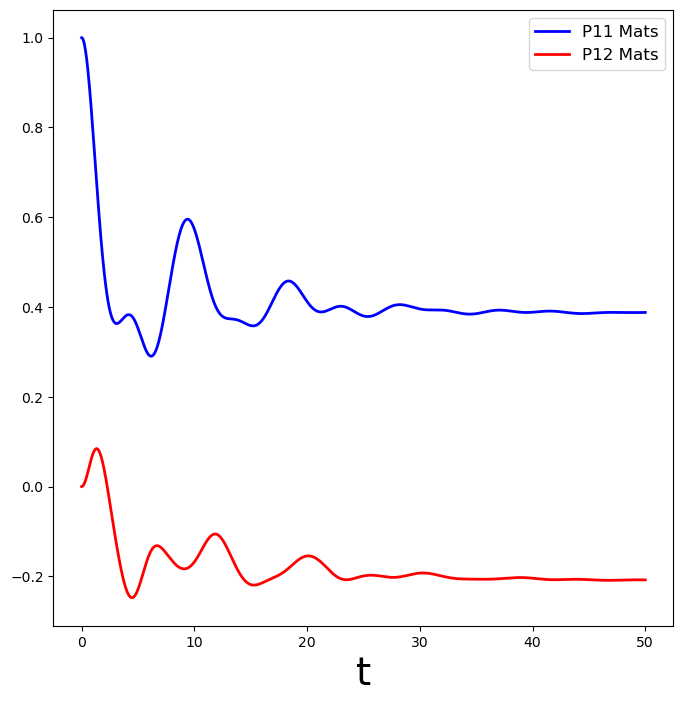

In [17]:
plot_result_expectations([
    (resultMats, P11p, 'b', "P11 Mats"),
    (resultMats, P12p, 'r', "P12 Mats"),
]);

In practice, one would not perform this laborious expansion for the underdamped correlation function, because
QuTiP already has a class, `UnderDampedEnvironment`, that can construct this bath for you. Nevertheless, knowing how
to perform this expansion is an useful skill.

Below we show how to use this built-in functionality:

In [18]:
# Compare to built-in under-damped bath:

with timer("RHS construction time"):
    env = UnderDampedEnvironment(lam=lam, gamma=gamma, w0=w0, T=T)
    env_approx = env.approximate("matsubara", Nk=Nk)
    HEOM_udbath = HEOMSolver(Hsys, (env_approx, Q), NC, options=options)

with timer("ODE solver time"):
    result_udbath = HEOM_udbath.run(rho0, tlist)

RHS construction time: 0.036414146423339844


 [          0%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [          0%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          0%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          0%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:01

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:01

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:01

 [          1%           ] Elapsed 0.02s / Remaining 00:00:00:01

 [          1%           ] Elapsed 0.02s / Remaining 00:00:00:01

 [          1%           ] Elapsed 0.02s / Remaining 00:00:00:01

 [          1%           ] Elapsed 0.02s / Remaining 00:00:00:02

 [          1%           ] Elapsed 0.02s / Remaining 00:00:00:02

 [          1%           ] Elapsed 0.02s / Remaining 00:00:00:02

 [          1%           ] Elapsed 0.03s / Remaining 00:00:00:02

 [          2%           ] Elapsed 0.03s / Remaining 00:00:00:01

 [          2%           ] Elapsed 0.04s / Remaining 00:00:00:01

 [          2%           ] Elapsed 0.04s / Remaining 00:00:00:01

 [          2%           ] Elapsed 0.04s / Remaining 00:00:00:01

 [          2%           ] Elapsed 0.04s / Remaining 00:00:00:02

 [          2%           ] Elapsed 0.05s / Remaining 00:00:00:02

 [          2%           ] Elapsed 0.05s / Remaining 00:00:00:02

 [          2%           ] Elapsed 0.05s / Remaining 00:00:00:02

 [          2%           ] Elapsed 0.06s / Remaining 00:00:00:02

 [          2%           ] Elapsed 0.06s / Remaining 00:00:00:02

 [*         3%           ] Elapsed 0.06s / Remaining 00:00:00:01

 [*         3%           ] Elapsed 0.07s / Remaining 00:00:00:02

 [*         3%           ] Elapsed 0.07s / Remaining 00:00:00:02

 [*         3%           ] Elapsed 0.07s / Remaining 00:00:00:02

 [*         3%           ] Elapsed 0.07s / Remaining 00:00:00:02

 [*         3%           ] Elapsed 0.08s / Remaining 00:00:00:02

 [*         3%           ] Elapsed 0.08s / Remaining 00:00:00:02

 [*         3%           ] Elapsed 0.08s / Remaining 00:00:00:02

 [*         3%           ] Elapsed 0.09s / Remaining 00:00:00:02

 [*         3%           ] Elapsed 0.09s / Remaining 00:00:00:02

 [*         4%           ] Elapsed 0.09s / Remaining 00:00:00:02

 [*         4%           ] Elapsed 0.10s / Remaining 00:00:00:02

 [*         4%           ] Elapsed 0.10s / Remaining 00:00:00:02

 [*         4%           ] Elapsed 0.10s / Remaining 00:00:00:02

 [*         4%           ] Elapsed 0.11s / Remaining 00:00:00:02

 [*         4%           ] Elapsed 0.11s / Remaining 00:00:00:02

 [*         4%           ] Elapsed 0.11s / Remaining 00:00:00:02

 [*         4%           ] Elapsed 0.12s / Remaining 00:00:00:02

 [*         4%           ] Elapsed 0.12s / Remaining 00:00:00:02

 [*         4%           ] Elapsed 0.12s / Remaining 00:00:00:02

 [*         5%           ] Elapsed 0.13s / Remaining 00:00:00:02

 [*         5%           ] Elapsed 0.13s / Remaining 00:00:00:02

 [*         5%           ] Elapsed 0.13s / Remaining 00:00:00:02

 [*         5%           ] Elapsed 0.14s / Remaining 00:00:00:02

 [*         5%           ] Elapsed 0.14s / Remaining 00:00:00:02

 [*         5%           ] Elapsed 0.14s / Remaining 00:00:00:02

 [*         5%           ] Elapsed 0.15s / Remaining 00:00:00:02

 [*         5%           ] Elapsed 0.15s / Remaining 00:00:00:02

 [*         5%           ] Elapsed 0.15s / Remaining 00:00:00:02

 [*         5%           ] Elapsed 0.15s / Remaining 00:00:00:02

 [*         6%           ] Elapsed 0.16s / Remaining 00:00:00:02

 [*         6%           ] Elapsed 0.16s / Remaining 00:00:00:02

 [*         6%           ] Elapsed 0.16s / Remaining 00:00:00:02

 [*         6%           ] Elapsed 0.17s / Remaining 00:00:00:02

 [*         6%           ] Elapsed 0.17s / Remaining 00:00:00:02

 [*         6%           ] Elapsed 0.17s / Remaining 00:00:00:02

 [*         6%           ] Elapsed 0.18s / Remaining 00:00:00:02

 [*         6%           ] Elapsed 0.18s / Remaining 00:00:00:02

 [*         6%           ] Elapsed 0.18s / Remaining 00:00:00:02

 [*         6%           ] Elapsed 0.18s / Remaining 00:00:00:02

 [**        7%           ] Elapsed 0.19s / Remaining 00:00:00:02

 [**        7%           ] Elapsed 0.19s / Remaining 00:00:00:02

 [**        7%           ] Elapsed 0.19s / Remaining 00:00:00:02

 [**        7%           ] Elapsed 0.20s / Remaining 00:00:00:02

 [**        7%           ] Elapsed 0.20s / Remaining 00:00:00:02

 [**        7%           ] Elapsed 0.20s / Remaining 00:00:00:02

 [**        7%           ] Elapsed 0.21s / Remaining 00:00:00:02

 [**        7%           ] Elapsed 0.21s / Remaining 00:00:00:02

 [**        7%           ] Elapsed 0.21s / Remaining 00:00:00:02

 [**        7%           ] Elapsed 0.22s / Remaining 00:00:00:02

 [**        8%           ] Elapsed 0.22s / Remaining 00:00:00:02

 [**        8%           ] Elapsed 0.22s / Remaining 00:00:00:02

 [**        8%           ] Elapsed 0.22s / Remaining 00:00:00:02

 [**        8%           ] Elapsed 0.23s / Remaining 00:00:00:02

 [**        8%           ] Elapsed 0.23s / Remaining 00:00:00:02

 [**        8%           ] Elapsed 0.23s / Remaining 00:00:00:02

 [**        8%           ] Elapsed 0.24s / Remaining 00:00:00:02

 [**        8%           ] Elapsed 0.24s / Remaining 00:00:00:02

 [**        8%           ] Elapsed 0.24s / Remaining 00:00:00:02

 [**        8%           ] Elapsed 0.25s / Remaining 00:00:00:02

 [**        9%           ] Elapsed 0.25s / Remaining 00:00:00:02

 [**        9%           ] Elapsed 0.25s / Remaining 00:00:00:02

 [**        9%           ] Elapsed 0.26s / Remaining 00:00:00:02

 [**        9%           ] Elapsed 0.26s / Remaining 00:00:00:02

 [**        9%           ] Elapsed 0.26s / Remaining 00:00:00:02

 [**        9%           ] Elapsed 0.27s / Remaining 00:00:00:02

 [**        9%           ] Elapsed 0.27s / Remaining 00:00:00:02

 [**        9%           ] Elapsed 0.27s / Remaining 00:00:00:02

 [**        9%           ] Elapsed 0.28s / Remaining 00:00:00:02

 [**        9%           ] Elapsed 0.28s / Remaining 00:00:00:02

 [**       10%           ] Elapsed 0.28s / Remaining 00:00:00:02

 [**       10%           ] Elapsed 0.29s / Remaining 00:00:00:02

 [**       10%           ] Elapsed 0.29s / Remaining 00:00:00:02

 [**       10%           ] Elapsed 0.30s / Remaining 00:00:00:02

 [**       10%           ] Elapsed 0.30s / Remaining 00:00:00:02

 [**       10%           ] Elapsed 0.30s / Remaining 00:00:00:02

 [**       10%           ] Elapsed 0.30s / Remaining 00:00:00:02

 [**       10%           ] Elapsed 0.31s / Remaining 00:00:00:02

 [**       10%           ] Elapsed 0.31s / Remaining 00:00:00:02

 [**       10%           ] Elapsed 0.31s / Remaining 00:00:00:02

 [***      11%           ] Elapsed 0.32s / Remaining 00:00:00:02

 [***      11%           ] Elapsed 0.32s / Remaining 00:00:00:02

 [***      11%           ] Elapsed 0.32s / Remaining 00:00:00:02

 [***      11%           ] Elapsed 0.33s / Remaining 00:00:00:02

 [***      11%           ] Elapsed 0.33s / Remaining 00:00:00:02

 [***      11%           ] Elapsed 0.33s / Remaining 00:00:00:02

 [***      11%           ] Elapsed 0.33s / Remaining 00:00:00:02

 [***      11%           ] Elapsed 0.34s / Remaining 00:00:00:02

 [***      11%           ] Elapsed 0.34s / Remaining 00:00:00:02

 [***      11%           ] Elapsed 0.34s / Remaining 00:00:00:02

 [***      12%           ] Elapsed 0.35s / Remaining 00:00:00:02

 [***      12%           ] Elapsed 0.35s / Remaining 00:00:00:02

 [***      12%           ] Elapsed 0.35s / Remaining 00:00:00:02

 [***      12%           ] Elapsed 0.36s / Remaining 00:00:00:02

 [***      12%           ] Elapsed 0.36s / Remaining 00:00:00:02

 [***      12%           ] Elapsed 0.36s / Remaining 00:00:00:02

 [***      12%           ] Elapsed 0.37s / Remaining 00:00:00:02

 [***      12%           ] Elapsed 0.37s / Remaining 00:00:00:02

 [***      12%           ] Elapsed 0.37s / Remaining 00:00:00:02

 [***      12%           ] Elapsed 0.38s / Remaining 00:00:00:02

 [***      13%           ] Elapsed 0.38s / Remaining 00:00:00:02

 [***      13%           ] Elapsed 0.38s / Remaining 00:00:00:02

 [***      13%           ] Elapsed 0.38s / Remaining 00:00:00:02

 [***      13%           ] Elapsed 0.39s / Remaining 00:00:00:02

 [***      13%           ] Elapsed 0.39s / Remaining 00:00:00:02

 [***      13%           ] Elapsed 0.39s / Remaining 00:00:00:02

 [***      13%           ] Elapsed 0.40s / Remaining 00:00:00:02

 [***      13%           ] Elapsed 0.40s / Remaining 00:00:00:02

 [***      13%           ] Elapsed 0.40s / Remaining 00:00:00:02

 [***      13%           ] Elapsed 0.41s / Remaining 00:00:00:02

 [***      14%           ] Elapsed 0.41s / Remaining 00:00:00:02

 [***      14%           ] Elapsed 0.41s / Remaining 00:00:00:02

 [***      14%           ] Elapsed 0.41s / Remaining 00:00:00:02

 [***      14%           ] Elapsed 0.42s / Remaining 00:00:00:02

 [***      14%           ] Elapsed 0.42s / Remaining 00:00:00:02

 [***      14%           ] Elapsed 0.43s / Remaining 00:00:00:02

 [***      14%           ] Elapsed 0.43s / Remaining 00:00:00:02

 [***      14%           ] Elapsed 0.43s / Remaining 00:00:00:02

 [***      14%           ] Elapsed 0.43s / Remaining 00:00:00:02

 [***      14%           ] Elapsed 0.44s / Remaining 00:00:00:02

 [***      15%           ] Elapsed 0.44s / Remaining 00:00:00:02

 [***      15%           ] Elapsed 0.44s / Remaining 00:00:00:02

 [***      15%           ] Elapsed 0.45s / Remaining 00:00:00:02

 [***      15%           ] Elapsed 0.45s / Remaining 00:00:00:02

 [***      15%           ] Elapsed 0.45s / Remaining 00:00:00:02

 [***      15%           ] Elapsed 0.46s / Remaining 00:00:00:02

 [***      15%           ] Elapsed 0.46s / Remaining 00:00:00:02

 [***      15%           ] Elapsed 0.46s / Remaining 00:00:00:02

 [***      15%           ] Elapsed 0.47s / Remaining 00:00:00:02

 [***      15%           ] Elapsed 0.47s / Remaining 00:00:00:02

 [****     16%           ] Elapsed 0.47s / Remaining 00:00:00:02

 [****     16%           ] Elapsed 0.48s / Remaining 00:00:00:02

 [****     16%           ] Elapsed 0.48s / Remaining 00:00:00:02

 [****     16%           ] Elapsed 0.48s / Remaining 00:00:00:02

 [****     16%           ] Elapsed 0.49s / Remaining 00:00:00:02

 [****     16%           ] Elapsed 0.49s / Remaining 00:00:00:02

 [****     16%           ] Elapsed 0.49s / Remaining 00:00:00:02

 [****     16%           ] Elapsed 0.50s / Remaining 00:00:00:02

 [****     16%           ] Elapsed 0.50s / Remaining 00:00:00:02

 [****     16%           ] Elapsed 0.50s / Remaining 00:00:00:02

 [****     17%           ] Elapsed 0.51s / Remaining 00:00:00:02

 [****     17%           ] Elapsed 0.51s / Remaining 00:00:00:02

 [****     17%           ] Elapsed 0.51s / Remaining 00:00:00:02

 [****     17%           ] Elapsed 0.52s / Remaining 00:00:00:02

 [****     17%           ] Elapsed 0.52s / Remaining 00:00:00:02

 [****     17%           ] Elapsed 0.52s / Remaining 00:00:00:02

 [****     17%           ] Elapsed 0.52s / Remaining 00:00:00:02

 [****     17%           ] Elapsed 0.53s / Remaining 00:00:00:02

 [****     17%           ] Elapsed 0.53s / Remaining 00:00:00:02

 [****     17%           ] Elapsed 0.53s / Remaining 00:00:00:02

 [****     18%           ] Elapsed 0.54s / Remaining 00:00:00:02

 [****     18%           ] Elapsed 0.54s / Remaining 00:00:00:02

 [****     18%           ] Elapsed 0.54s / Remaining 00:00:00:02

 [****     18%           ] Elapsed 0.55s / Remaining 00:00:00:02

 [****     18%           ] Elapsed 0.55s / Remaining 00:00:00:02

 [****     18%           ] Elapsed 0.55s / Remaining 00:00:00:02

 [****     18%           ] Elapsed 0.55s / Remaining 00:00:00:02

 [****     18%           ] Elapsed 0.56s / Remaining 00:00:00:02

 [****     18%           ] Elapsed 0.56s / Remaining 00:00:00:02

 [****     18%           ] Elapsed 0.56s / Remaining 00:00:00:02

 [****     19%           ] Elapsed 0.57s / Remaining 00:00:00:02

 [****     19%           ] Elapsed 0.57s / Remaining 00:00:00:02

 [****     19%           ] Elapsed 0.57s / Remaining 00:00:00:02

 [****     19%           ] Elapsed 0.58s / Remaining 00:00:00:02

 [****     19%           ] Elapsed 0.58s / Remaining 00:00:00:02

 [****     19%           ] Elapsed 0.58s / Remaining 00:00:00:02

 [****     19%           ] Elapsed 0.59s / Remaining 00:00:00:02

 [****     19%           ] Elapsed 0.59s / Remaining 00:00:00:02

 [****     19%           ] Elapsed 0.59s / Remaining 00:00:00:02

 [****     19%           ] Elapsed 0.59s / Remaining 00:00:00:02

 [*****    20%           ] Elapsed 0.60s / Remaining 00:00:00:02

 [*****    20%           ] Elapsed 0.60s / Remaining 00:00:00:02

 [*****    20%           ] Elapsed 0.61s / Remaining 00:00:00:02

 [*****    20%           ] Elapsed 0.61s / Remaining 00:00:00:02

 [*****    20%           ] Elapsed 0.61s / Remaining 00:00:00:02

 [*****    20%           ] Elapsed 0.61s / Remaining 00:00:00:02

 [*****    20%           ] Elapsed 0.62s / Remaining 00:00:00:02

 [*****    20%           ] Elapsed 0.62s / Remaining 00:00:00:02

 [*****    20%           ] Elapsed 0.62s / Remaining 00:00:00:02

 [*****    20%           ] Elapsed 0.63s / Remaining 00:00:00:02

 [*****    21%           ] Elapsed 0.63s / Remaining 00:00:00:02

 [*****    21%           ] Elapsed 0.63s / Remaining 00:00:00:02

 [*****    21%           ] Elapsed 0.64s / Remaining 00:00:00:02

 [*****    21%           ] Elapsed 0.64s / Remaining 00:00:00:02

 [*****    21%           ] Elapsed 0.64s / Remaining 00:00:00:02

 [*****    21%           ] Elapsed 0.65s / Remaining 00:00:00:02

 [*****    21%           ] Elapsed 0.65s / Remaining 00:00:00:02

 [*****    21%           ] Elapsed 0.65s / Remaining 00:00:00:02

 [*****    21%           ] Elapsed 0.66s / Remaining 00:00:00:02

 [*****    21%           ] Elapsed 0.66s / Remaining 00:00:00:02

 [*****    22%           ] Elapsed 0.66s / Remaining 00:00:00:02

 [*****    22%           ] Elapsed 0.67s / Remaining 00:00:00:02

 [*****    22%           ] Elapsed 0.67s / Remaining 00:00:00:02

 [*****    22%           ] Elapsed 0.67s / Remaining 00:00:00:02

 [*****    22%           ] Elapsed 0.68s / Remaining 00:00:00:02

 [*****    22%           ] Elapsed 0.68s / Remaining 00:00:00:02

 [*****    22%           ] Elapsed 0.68s / Remaining 00:00:00:02

 [*****    22%           ] Elapsed 0.69s / Remaining 00:00:00:02

 [*****    22%           ] Elapsed 0.69s / Remaining 00:00:00:02

 [*****    22%           ] Elapsed 0.69s / Remaining 00:00:00:02

 [*****    23%           ] Elapsed 0.69s / Remaining 00:00:00:02

 [*****    23%           ] Elapsed 0.70s / Remaining 00:00:00:02

 [*****    23%           ] Elapsed 0.70s / Remaining 00:00:00:02

 [*****    23%           ] Elapsed 0.70s / Remaining 00:00:00:02

 [*****    23%           ] Elapsed 0.71s / Remaining 00:00:00:02

 [*****    23%           ] Elapsed 0.71s / Remaining 00:00:00:02

 [*****    23%           ] Elapsed 0.71s / Remaining 00:00:00:02

 [*****    23%           ] Elapsed 0.72s / Remaining 00:00:00:02

 [*****    23%           ] Elapsed 0.72s / Remaining 00:00:00:02

 [*****    23%           ] Elapsed 0.72s / Remaining 00:00:00:02

 [******   24%           ] Elapsed 0.73s / Remaining 00:00:00:02

 [******   24%           ] Elapsed 0.73s / Remaining 00:00:00:02

 [******   24%           ] Elapsed 0.73s / Remaining 00:00:00:02

 [******   24%           ] Elapsed 0.73s / Remaining 00:00:00:02

 [******   24%           ] Elapsed 0.74s / Remaining 00:00:00:02

 [******   24%           ] Elapsed 0.74s / Remaining 00:00:00:02

 [******   24%           ] Elapsed 0.74s / Remaining 00:00:00:02

 [******   24%           ] Elapsed 0.75s / Remaining 00:00:00:02

 [******   24%           ] Elapsed 0.75s / Remaining 00:00:00:02

 [******   24%           ] Elapsed 0.75s / Remaining 00:00:00:02

 [******   25%           ] Elapsed 0.76s / Remaining 00:00:00:02

 [******   25%           ] Elapsed 0.76s / Remaining 00:00:00:02

 [******   25%           ] Elapsed 0.76s / Remaining 00:00:00:02

 [******   25%           ] Elapsed 0.77s / Remaining 00:00:00:02

 [******   25%           ] Elapsed 0.77s / Remaining 00:00:00:02

 [******   25%           ] Elapsed 0.77s / Remaining 00:00:00:02

 [******   25%           ] Elapsed 0.77s / Remaining 00:00:00:02

 [******   25%           ] Elapsed 0.78s / Remaining 00:00:00:02

 [******   25%           ] Elapsed 0.78s / Remaining 00:00:00:02

 [******   25%           ] Elapsed 0.79s / Remaining 00:00:00:02

 [******   26%           ] Elapsed 0.79s / Remaining 00:00:00:02

 [******   26%           ] Elapsed 0.79s / Remaining 00:00:00:02

 [******   26%           ] Elapsed 0.79s / Remaining 00:00:00:02

 [******   26%           ] Elapsed 0.80s / Remaining 00:00:00:02

 [******   26%           ] Elapsed 0.80s / Remaining 00:00:00:02

 [******   26%           ] Elapsed 0.80s / Remaining 00:00:00:02

 [******   26%           ] Elapsed 0.81s / Remaining 00:00:00:02

 [******   26%           ] Elapsed 0.81s / Remaining 00:00:00:02

 [******   26%           ] Elapsed 0.81s / Remaining 00:00:00:02

 [******   26%           ] Elapsed 0.82s / Remaining 00:00:00:02

 [******   27%           ] Elapsed 0.82s / Remaining 00:00:00:02

 [******   27%           ] Elapsed 0.82s / Remaining 00:00:00:02

 [******   27%           ] Elapsed 0.82s / Remaining 00:00:00:02

 [******   27%           ] Elapsed 0.83s / Remaining 00:00:00:02

 [******   27%           ] Elapsed 0.83s / Remaining 00:00:00:02

 [******   27%           ] Elapsed 0.83s / Remaining 00:00:00:02

 [******   27%           ] Elapsed 0.84s / Remaining 00:00:00:02

 [******   27%           ] Elapsed 0.84s / Remaining 00:00:00:02

 [******   27%           ] Elapsed 0.84s / Remaining 00:00:00:02

 [******   27%           ] Elapsed 0.85s / Remaining 00:00:00:02

 [******   28%           ] Elapsed 0.85s / Remaining 00:00:00:02

 [******   28%           ] Elapsed 0.85s / Remaining 00:00:00:02

 [******   28%           ] Elapsed 0.86s / Remaining 00:00:00:02

 [******   28%           ] Elapsed 0.86s / Remaining 00:00:00:02

 [******   28%           ] Elapsed 0.86s / Remaining 00:00:00:02

 [******   28%           ] Elapsed 0.87s / Remaining 00:00:00:02

 [******   28%           ] Elapsed 0.87s / Remaining 00:00:00:02

 [******   28%           ] Elapsed 0.87s / Remaining 00:00:00:02

 [******   28%           ] Elapsed 0.87s / Remaining 00:00:00:02

 [******   28%           ] Elapsed 0.88s / Remaining 00:00:00:02

 [*******  29%           ] Elapsed 0.88s / Remaining 00:00:00:02

 [*******  29%           ] Elapsed 0.88s / Remaining 00:00:00:02

 [*******  29%           ] Elapsed 0.89s / Remaining 00:00:00:02

 [*******  29%           ] Elapsed 0.89s / Remaining 00:00:00:02

 [*******  29%           ] Elapsed 0.89s / Remaining 00:00:00:02

 [*******  29%           ] Elapsed 0.89s / Remaining 00:00:00:02

 [*******  29%           ] Elapsed 0.90s / Remaining 00:00:00:02

 [*******  29%           ] Elapsed 0.90s / Remaining 00:00:00:02

 [*******  29%           ] Elapsed 0.90s / Remaining 00:00:00:02

 [*******  29%           ] Elapsed 0.91s / Remaining 00:00:00:02

 [*******  30%           ] Elapsed 0.91s / Remaining 00:00:00:02

 [*******  30%           ] Elapsed 0.91s / Remaining 00:00:00:02

 [*******  30%           ] Elapsed 0.92s / Remaining 00:00:00:02

 [*******  30%           ] Elapsed 0.92s / Remaining 00:00:00:02

 [*******  30%           ] Elapsed 0.92s / Remaining 00:00:00:02

 [*******  30%           ] Elapsed 0.92s / Remaining 00:00:00:02

 [*******  30%           ] Elapsed 0.93s / Remaining 00:00:00:02

 [*******  30%           ] Elapsed 0.93s / Remaining 00:00:00:02

 [*******  30%           ] Elapsed 0.93s / Remaining 00:00:00:02

 [*******  30%           ] Elapsed 0.94s / Remaining 00:00:00:02

 [*******  31%           ] Elapsed 0.94s / Remaining 00:00:00:02

 [*******  31%           ] Elapsed 0.94s / Remaining 00:00:00:02

 [*******  31%           ] Elapsed 0.95s / Remaining 00:00:00:02

 [*******  31%           ] Elapsed 0.95s / Remaining 00:00:00:02

 [*******  31%           ] Elapsed 0.95s / Remaining 00:00:00:02

 [*******  31%           ] Elapsed 0.95s / Remaining 00:00:00:02

 [*******  31%           ] Elapsed 0.96s / Remaining 00:00:00:02

 [*******  31%           ] Elapsed 0.96s / Remaining 00:00:00:02

 [*******  31%           ] Elapsed 0.96s / Remaining 00:00:00:02

 [*******  31%           ] Elapsed 0.97s / Remaining 00:00:00:02

 [*******  32%           ] Elapsed 0.97s / Remaining 00:00:00:02

 [*******  32%           ] Elapsed 0.97s / Remaining 00:00:00:02

 [*******  32%           ] Elapsed 0.98s / Remaining 00:00:00:02

 [*******  32%           ] Elapsed 0.98s / Remaining 00:00:00:02

 [*******  32%           ] Elapsed 0.98s / Remaining 00:00:00:02

 [*******  32%           ] Elapsed 0.98s / Remaining 00:00:00:02

 [*******  32%           ] Elapsed 0.99s / Remaining 00:00:00:02

 [*******  32%           ] Elapsed 0.99s / Remaining 00:00:00:02

 [*******  32%           ] Elapsed 0.99s / Remaining 00:00:00:02

 [*******  32%           ] Elapsed 1.00s / Remaining 00:00:00:02

 [******** 33%           ] Elapsed 1.00s / Remaining 00:00:00:02

 [******** 33%           ] Elapsed 1.00s / Remaining 00:00:00:02

 [******** 33%           ] Elapsed 1.01s / Remaining 00:00:00:02

 [******** 33%           ] Elapsed 1.01s / Remaining 00:00:00:02

 [******** 33%           ] Elapsed 1.01s / Remaining 00:00:00:02

 [******** 33%           ] Elapsed 1.02s / Remaining 00:00:00:02

 [******** 33%           ] Elapsed 1.02s / Remaining 00:00:00:02

 [******** 33%           ] Elapsed 1.02s / Remaining 00:00:00:02

 [******** 33%           ] Elapsed 1.03s / Remaining 00:00:00:02

 [******** 33%           ] Elapsed 1.03s / Remaining 00:00:00:02

 [******** 34%           ] Elapsed 1.03s / Remaining 00:00:00:02

 [******** 34%           ] Elapsed 1.03s / Remaining 00:00:00:02

 [******** 34%           ] Elapsed 1.04s / Remaining 00:00:00:02

 [******** 34%           ] Elapsed 1.04s / Remaining 00:00:00:02

 [******** 34%           ] Elapsed 1.04s / Remaining 00:00:00:02

 [******** 34%           ] Elapsed 1.05s / Remaining 00:00:00:02

 [******** 34%           ] Elapsed 1.05s / Remaining 00:00:00:02

 [******** 34%           ] Elapsed 1.05s / Remaining 00:00:00:02

 [******** 34%           ] Elapsed 1.06s / Remaining 00:00:00:02

 [******** 34%           ] Elapsed 1.06s / Remaining 00:00:00:02

 [******** 35%           ] Elapsed 1.06s / Remaining 00:00:00:01

 [******** 35%           ] Elapsed 1.07s / Remaining 00:00:00:01

 [******** 35%           ] Elapsed 1.07s / Remaining 00:00:00:01

 [******** 35%           ] Elapsed 1.07s / Remaining 00:00:00:01

 [******** 35%           ] Elapsed 1.07s / Remaining 00:00:00:01

 [******** 35%           ] Elapsed 1.08s / Remaining 00:00:00:02

 [******** 35%           ] Elapsed 1.08s / Remaining 00:00:00:02

 [******** 35%           ] Elapsed 1.08s / Remaining 00:00:00:02

 [******** 35%           ] Elapsed 1.09s / Remaining 00:00:00:02

 [******** 35%           ] Elapsed 1.09s / Remaining 00:00:00:02

 [******** 36%           ] Elapsed 1.09s / Remaining 00:00:00:01

 [******** 36%           ] Elapsed 1.10s / Remaining 00:00:00:01

 [******** 36%           ] Elapsed 1.10s / Remaining 00:00:00:01

 [******** 36%           ] Elapsed 1.10s / Remaining 00:00:00:01

 [******** 36%           ] Elapsed 1.11s / Remaining 00:00:00:01

 [******** 36%           ] Elapsed 1.11s / Remaining 00:00:00:01

 [******** 36%           ] Elapsed 1.11s / Remaining 00:00:00:01

 [******** 36%           ] Elapsed 1.11s / Remaining 00:00:00:01

 [******** 36%           ] Elapsed 1.12s / Remaining 00:00:00:01

 [******** 36%           ] Elapsed 1.12s / Remaining 00:00:00:01

 [*********37%           ] Elapsed 1.12s / Remaining 00:00:00:01

 [*********37%           ] Elapsed 1.13s / Remaining 00:00:00:01

 [*********37%           ] Elapsed 1.13s / Remaining 00:00:00:01

 [*********37%           ] Elapsed 1.13s / Remaining 00:00:00:01

 [*********37%           ] Elapsed 1.14s / Remaining 00:00:00:01

 [*********37%           ] Elapsed 1.14s / Remaining 00:00:00:01

 [*********37%           ] Elapsed 1.14s / Remaining 00:00:00:01

 [*********37%           ] Elapsed 1.14s / Remaining 00:00:00:01

 [*********37%           ] Elapsed 1.15s / Remaining 00:00:00:01

 [*********37%           ] Elapsed 1.15s / Remaining 00:00:00:01

 [*********38%           ] Elapsed 1.15s / Remaining 00:00:00:01

 [*********38%           ] Elapsed 1.16s / Remaining 00:00:00:01

 [*********38%           ] Elapsed 1.16s / Remaining 00:00:00:01

 [*********38%           ] Elapsed 1.16s / Remaining 00:00:00:01

 [*********38%           ] Elapsed 1.17s / Remaining 00:00:00:01

 [*********38%           ] Elapsed 1.17s / Remaining 00:00:00:01

 [*********38%           ] Elapsed 1.17s / Remaining 00:00:00:01

 [*********38%           ] Elapsed 1.18s / Remaining 00:00:00:01

 [*********38%           ] Elapsed 1.18s / Remaining 00:00:00:01

 [*********38%           ] Elapsed 1.18s / Remaining 00:00:00:01

 [*********39%           ] Elapsed 1.19s / Remaining 00:00:00:01

 [*********39%           ] Elapsed 1.19s / Remaining 00:00:00:01

 [*********39%           ] Elapsed 1.19s / Remaining 00:00:00:01

 [*********39%           ] Elapsed 1.20s / Remaining 00:00:00:01

 [*********39%           ] Elapsed 1.20s / Remaining 00:00:00:01

 [*********39%           ] Elapsed 1.20s / Remaining 00:00:00:01

 [*********39%           ] Elapsed 1.21s / Remaining 00:00:00:01

 [*********39%           ] Elapsed 1.21s / Remaining 00:00:00:01

 [*********39%           ] Elapsed 1.21s / Remaining 00:00:00:01

 [*********39%           ] Elapsed 1.22s / Remaining 00:00:00:01

 [*********40%           ] Elapsed 1.22s / Remaining 00:00:00:01

 [*********40%           ] Elapsed 1.22s / Remaining 00:00:00:01

 [*********40%           ] Elapsed 1.23s / Remaining 00:00:00:01

 [*********40%           ] Elapsed 1.23s / Remaining 00:00:00:01

 [*********40%           ] Elapsed 1.23s / Remaining 00:00:00:01

 [*********40%           ] Elapsed 1.23s / Remaining 00:00:00:01

 [*********40%           ] Elapsed 1.24s / Remaining 00:00:00:01

 [*********40%           ] Elapsed 1.24s / Remaining 00:00:00:01

 [*********40%           ] Elapsed 1.24s / Remaining 00:00:00:01

 [*********40%           ] Elapsed 1.25s / Remaining 00:00:00:01

 [*********41%           ] Elapsed 1.25s / Remaining 00:00:00:01

 [*********41%           ] Elapsed 1.25s / Remaining 00:00:00:01

 [*********41%           ] Elapsed 1.26s / Remaining 00:00:00:01

 [*********41%           ] Elapsed 1.26s / Remaining 00:00:00:01

 [*********41%           ] Elapsed 1.26s / Remaining 00:00:00:01

 [*********41%           ] Elapsed 1.26s / Remaining 00:00:00:01

 [*********41%           ] Elapsed 1.27s / Remaining 00:00:00:01

 [*********41%           ] Elapsed 1.27s / Remaining 00:00:00:01

 [*********41%           ] Elapsed 1.28s / Remaining 00:00:00:01

 [*********41%           ] Elapsed 1.28s / Remaining 00:00:00:01

 [*********42%           ] Elapsed 1.28s / Remaining 00:00:00:01

 [*********42%           ] Elapsed 1.28s / Remaining 00:00:00:01

 [*********42%           ] Elapsed 1.29s / Remaining 00:00:00:01

 [*********42%           ] Elapsed 1.29s / Remaining 00:00:00:01

 [*********42%           ] Elapsed 1.29s / Remaining 00:00:00:01

 [*********42%           ] Elapsed 1.30s / Remaining 00:00:00:01

 [*********42%           ] Elapsed 1.30s / Remaining 00:00:00:01

 [*********42%           ] Elapsed 1.30s / Remaining 00:00:00:01

 [*********42%           ] Elapsed 1.31s / Remaining 00:00:00:01

 [*********42%           ] Elapsed 1.31s / Remaining 00:00:00:01

 [*********43%           ] Elapsed 1.31s / Remaining 00:00:00:01

 [*********43%           ] Elapsed 1.32s / Remaining 00:00:00:01

 [*********43%           ] Elapsed 1.32s / Remaining 00:00:00:01

 [*********43%           ] Elapsed 1.32s / Remaining 00:00:00:01

 [*********43%           ] Elapsed 1.32s / Remaining 00:00:00:01

 [*********43%           ] Elapsed 1.33s / Remaining 00:00:00:01

 [*********43%           ] Elapsed 1.33s / Remaining 00:00:00:01

 [*********43%           ] Elapsed 1.33s / Remaining 00:00:00:01

 [*********43%           ] Elapsed 1.34s / Remaining 00:00:00:01

 [*********43%           ] Elapsed 1.34s / Remaining 00:00:00:01

 [*********44%           ] Elapsed 1.34s / Remaining 00:00:00:01

 [*********44%           ] Elapsed 1.35s / Remaining 00:00:00:01

 [*********44%           ] Elapsed 1.35s / Remaining 00:00:00:01

 [*********44%           ] Elapsed 1.35s / Remaining 00:00:00:01

 [*********44%           ] Elapsed 1.36s / Remaining 00:00:00:01

 [*********44%           ] Elapsed 1.36s / Remaining 00:00:00:01

 [*********44%           ] Elapsed 1.36s / Remaining 00:00:00:01

 [*********44%           ] Elapsed 1.37s / Remaining 00:00:00:01

 [*********44%           ] Elapsed 1.37s / Remaining 00:00:00:01

 [*********44%           ] Elapsed 1.37s / Remaining 00:00:00:01

 [*********45%           ] Elapsed 1.38s / Remaining 00:00:00:01

 [*********45%           ] Elapsed 1.38s / Remaining 00:00:00:01

 [*********45%           ] Elapsed 1.38s / Remaining 00:00:00:01

 [*********45%           ] Elapsed 1.39s / Remaining 00:00:00:01

 [*********45%           ] Elapsed 1.39s / Remaining 00:00:00:01

 [*********45%           ] Elapsed 1.39s / Remaining 00:00:00:01

 [*********45%           ] Elapsed 1.40s / Remaining 00:00:00:01

 [*********45%           ] Elapsed 1.40s / Remaining 00:00:00:01

 [*********45%           ] Elapsed 1.40s / Remaining 00:00:00:01

 [*********45%           ] Elapsed 1.41s / Remaining 00:00:00:01

 [*********46%           ] Elapsed 1.41s / Remaining 00:00:00:01

 [*********46%           ] Elapsed 1.41s / Remaining 00:00:00:01

 [*********46%           ] Elapsed 1.41s / Remaining 00:00:00:01

 [*********46%           ] Elapsed 1.42s / Remaining 00:00:00:01

 [*********46%           ] Elapsed 1.42s / Remaining 00:00:00:01

 [*********46%           ] Elapsed 1.42s / Remaining 00:00:00:01

 [*********46%           ] Elapsed 1.43s / Remaining 00:00:00:01

 [*********46%           ] Elapsed 1.43s / Remaining 00:00:00:01

 [*********46%           ] Elapsed 1.43s / Remaining 00:00:00:01

 [*********46%           ] Elapsed 1.44s / Remaining 00:00:00:01

 [*********47%           ] Elapsed 1.44s / Remaining 00:00:00:01

 [*********47%           ] Elapsed 1.44s / Remaining 00:00:00:01

 [*********47%           ] Elapsed 1.44s / Remaining 00:00:00:01

 [*********47%           ] Elapsed 1.45s / Remaining 00:00:00:01

 [*********47%           ] Elapsed 1.45s / Remaining 00:00:00:01

 [*********47%           ] Elapsed 1.45s / Remaining 00:00:00:01

 [*********47%           ] Elapsed 1.46s / Remaining 00:00:00:01

 [*********47%           ] Elapsed 1.46s / Remaining 00:00:00:01

 [*********47%           ] Elapsed 1.46s / Remaining 00:00:00:01

 [*********47%           ] Elapsed 1.47s / Remaining 00:00:00:01

 [*********48%           ] Elapsed 1.47s / Remaining 00:00:00:01

 [*********48%           ] Elapsed 1.47s / Remaining 00:00:00:01

 [*********48%           ] Elapsed 1.48s / Remaining 00:00:00:01

 [*********48%           ] Elapsed 1.48s / Remaining 00:00:00:01

 [*********48%           ] Elapsed 1.48s / Remaining 00:00:00:01

 [*********48%           ] Elapsed 1.48s / Remaining 00:00:00:01

 [*********48%           ] Elapsed 1.49s / Remaining 00:00:00:01

 [*********48%           ] Elapsed 1.49s / Remaining 00:00:00:01

 [*********48%           ] Elapsed 1.49s / Remaining 00:00:00:01

 [*********48%           ] Elapsed 1.50s / Remaining 00:00:00:01

 [*********49%           ] Elapsed 1.50s / Remaining 00:00:00:01

 [*********49%           ] Elapsed 1.50s / Remaining 00:00:00:01

 [*********49%           ] Elapsed 1.50s / Remaining 00:00:00:01

 [*********49%           ] Elapsed 1.51s / Remaining 00:00:00:01

 [*********49%           ] Elapsed 1.51s / Remaining 00:00:00:01

 [*********49%           ] Elapsed 1.52s / Remaining 00:00:00:01

 [*********49%           ] Elapsed 1.52s / Remaining 00:00:00:01

 [*********49%           ] Elapsed 1.52s / Remaining 00:00:00:01

 [*********49%           ] Elapsed 1.53s / Remaining 00:00:00:01

 [*********49%           ] Elapsed 1.53s / Remaining 00:00:00:01

 [*********50%           ] Elapsed 1.53s / Remaining 00:00:00:01

 [*********50%           ] Elapsed 1.53s / Remaining 00:00:00:01

 [*********50%           ] Elapsed 1.54s / Remaining 00:00:00:01

 [*********50%           ] Elapsed 1.54s / Remaining 00:00:00:01

 [*********50%           ] Elapsed 1.54s / Remaining 00:00:00:01

 [*********50%           ] Elapsed 1.55s / Remaining 00:00:00:01

 [*********50%           ] Elapsed 1.55s / Remaining 00:00:00:01

 [*********50%           ] Elapsed 1.55s / Remaining 00:00:00:01

 [*********50%           ] Elapsed 1.56s / Remaining 00:00:00:01

 [*********50%           ] Elapsed 1.56s / Remaining 00:00:00:01

 [*********51%           ] Elapsed 1.56s / Remaining 00:00:00:01

 [*********51%           ] Elapsed 1.57s / Remaining 00:00:00:01

 [*********51%           ] Elapsed 1.57s / Remaining 00:00:00:01

 [*********51%           ] Elapsed 1.57s / Remaining 00:00:00:01

 [*********51%           ] Elapsed 1.58s / Remaining 00:00:00:01

 [*********51%           ] Elapsed 1.58s / Remaining 00:00:00:01

 [*********51%           ] Elapsed 1.58s / Remaining 00:00:00:01

 [*********51%           ] Elapsed 1.59s / Remaining 00:00:00:01

 [*********51%           ] Elapsed 1.59s / Remaining 00:00:00:01

 [*********51%           ] Elapsed 1.59s / Remaining 00:00:00:01

 [*********52%           ] Elapsed 1.60s / Remaining 00:00:00:01

 [*********52%           ] Elapsed 1.60s / Remaining 00:00:00:01

 [*********52%           ] Elapsed 1.60s / Remaining 00:00:00:01

 [*********52%           ] Elapsed 1.60s / Remaining 00:00:00:01

 [*********52%           ] Elapsed 1.61s / Remaining 00:00:00:01

 [*********52%           ] Elapsed 1.61s / Remaining 00:00:00:01

 [*********52%           ] Elapsed 1.61s / Remaining 00:00:00:01

 [*********52%           ] Elapsed 1.62s / Remaining 00:00:00:01

 [*********52%           ] Elapsed 1.62s / Remaining 00:00:00:01

 [*********52%           ] Elapsed 1.62s / Remaining 00:00:00:01

 [*********53%           ] Elapsed 1.63s / Remaining 00:00:00:01

 [*********53%           ] Elapsed 1.63s / Remaining 00:00:00:01

 [*********53%           ] Elapsed 1.63s / Remaining 00:00:00:01

 [*********53%           ] Elapsed 1.64s / Remaining 00:00:00:01

 [*********53%           ] Elapsed 1.64s / Remaining 00:00:00:01

 [*********53%           ] Elapsed 1.64s / Remaining 00:00:00:01

 [*********53%           ] Elapsed 1.64s / Remaining 00:00:00:01

 [*********53%           ] Elapsed 1.65s / Remaining 00:00:00:01

 [*********53%           ] Elapsed 1.65s / Remaining 00:00:00:01

 [*********53%           ] Elapsed 1.65s / Remaining 00:00:00:01

 [*********54%           ] Elapsed 1.66s / Remaining 00:00:00:01

 [*********54%           ] Elapsed 1.66s / Remaining 00:00:00:01

 [*********54%           ] Elapsed 1.66s / Remaining 00:00:00:01

 [*********54%           ] Elapsed 1.67s / Remaining 00:00:00:01

 [*********54%           ] Elapsed 1.67s / Remaining 00:00:00:01

 [*********54%           ] Elapsed 1.67s / Remaining 00:00:00:01

 [*********54%           ] Elapsed 1.68s / Remaining 00:00:00:01

 [*********54%           ] Elapsed 1.68s / Remaining 00:00:00:01

 [*********54%           ] Elapsed 1.68s / Remaining 00:00:00:01

 [*********54%           ] Elapsed 1.68s / Remaining 00:00:00:01

 [*********55%*          ] Elapsed 1.69s / Remaining 00:00:00:01

 [*********55%*          ] Elapsed 1.69s / Remaining 00:00:00:01

 [*********55%*          ] Elapsed 1.69s / Remaining 00:00:00:01

 [*********55%*          ] Elapsed 1.70s / Remaining 00:00:00:01

 [*********55%*          ] Elapsed 1.70s / Remaining 00:00:00:01

 [*********55%*          ] Elapsed 1.70s / Remaining 00:00:00:01

 [*********55%*          ] Elapsed 1.71s / Remaining 00:00:00:01

 [*********55%*          ] Elapsed 1.71s / Remaining 00:00:00:01

 [*********55%*          ] Elapsed 1.71s / Remaining 00:00:00:01

 [*********55%*          ] Elapsed 1.72s / Remaining 00:00:00:01

 [*********56%*          ] Elapsed 1.72s / Remaining 00:00:00:01

 [*********56%*          ] Elapsed 1.72s / Remaining 00:00:00:01

 [*********56%*          ] Elapsed 1.73s / Remaining 00:00:00:01

 [*********56%*          ] Elapsed 1.73s / Remaining 00:00:00:01

 [*********56%*          ] Elapsed 1.73s / Remaining 00:00:00:01

 [*********56%*          ] Elapsed 1.74s / Remaining 00:00:00:01

 [*********56%*          ] Elapsed 1.74s / Remaining 00:00:00:01

 [*********56%*          ] Elapsed 1.74s / Remaining 00:00:00:01

 [*********56%*          ] Elapsed 1.75s / Remaining 00:00:00:01

 [*********56%*          ] Elapsed 1.75s / Remaining 00:00:00:01

 [*********57%*          ] Elapsed 1.75s / Remaining 00:00:00:01

 [*********57%*          ] Elapsed 1.76s / Remaining 00:00:00:01

 [*********57%*          ] Elapsed 1.76s / Remaining 00:00:00:01

 [*********57%*          ] Elapsed 1.76s / Remaining 00:00:00:01

 [*********57%*          ] Elapsed 1.77s / Remaining 00:00:00:01

 [*********57%*          ] Elapsed 1.77s / Remaining 00:00:00:01

 [*********57%*          ] Elapsed 1.77s / Remaining 00:00:00:01

 [*********57%*          ] Elapsed 1.78s / Remaining 00:00:00:01

 [*********57%*          ] Elapsed 1.78s / Remaining 00:00:00:01

 [*********57%*          ] Elapsed 1.78s / Remaining 00:00:00:01

 [*********58%*          ] Elapsed 1.79s / Remaining 00:00:00:01

 [*********58%*          ] Elapsed 1.79s / Remaining 00:00:00:01

 [*********58%*          ] Elapsed 1.79s / Remaining 00:00:00:01

 [*********58%*          ] Elapsed 1.79s / Remaining 00:00:00:01

 [*********58%*          ] Elapsed 1.80s / Remaining 00:00:00:01

 [*********58%*          ] Elapsed 1.80s / Remaining 00:00:00:01

 [*********58%*          ] Elapsed 1.80s / Remaining 00:00:00:01

 [*********58%*          ] Elapsed 1.81s / Remaining 00:00:00:01

 [*********58%*          ] Elapsed 1.81s / Remaining 00:00:00:01

 [*********58%*          ] Elapsed 1.81s / Remaining 00:00:00:01

 [*********59%**         ] Elapsed 1.82s / Remaining 00:00:00:01

 [*********59%**         ] Elapsed 1.82s / Remaining 00:00:00:01

 [*********59%**         ] Elapsed 1.82s / Remaining 00:00:00:01

 [*********59%**         ] Elapsed 1.82s / Remaining 00:00:00:01

 [*********59%**         ] Elapsed 1.83s / Remaining 00:00:00:01

 [*********59%**         ] Elapsed 1.83s / Remaining 00:00:00:01

 [*********59%**         ] Elapsed 1.83s / Remaining 00:00:00:01

 [*********59%**         ] Elapsed 1.84s / Remaining 00:00:00:01

 [*********59%**         ] Elapsed 1.84s / Remaining 00:00:00:01

 [*********59%**         ] Elapsed 1.84s / Remaining 00:00:00:01

 [*********60%**         ] Elapsed 1.85s / Remaining 00:00:00:01

 [*********60%**         ] Elapsed 1.85s / Remaining 00:00:00:01

 [*********60%**         ] Elapsed 1.85s / Remaining 00:00:00:01

 [*********60%**         ] Elapsed 1.86s / Remaining 00:00:00:01

 [*********60%**         ] Elapsed 1.86s / Remaining 00:00:00:01

 [*********60%**         ] Elapsed 1.86s / Remaining 00:00:00:01

 [*********60%**         ] Elapsed 1.87s / Remaining 00:00:00:01

 [*********60%**         ] Elapsed 1.87s / Remaining 00:00:00:01

 [*********60%**         ] Elapsed 1.87s / Remaining 00:00:00:01

 [*********60%**         ] Elapsed 1.88s / Remaining 00:00:00:01

 [*********61%**         ] Elapsed 1.88s / Remaining 00:00:00:01

 [*********61%**         ] Elapsed 1.88s / Remaining 00:00:00:01

 [*********61%**         ] Elapsed 1.89s / Remaining 00:00:00:01

 [*********61%**         ] Elapsed 1.89s / Remaining 00:00:00:01

 [*********61%**         ] Elapsed 1.89s / Remaining 00:00:00:01

 [*********61%**         ] Elapsed 1.90s / Remaining 00:00:00:01

 [*********61%**         ] Elapsed 1.90s / Remaining 00:00:00:01

 [*********61%**         ] Elapsed 1.90s / Remaining 00:00:00:01

 [*********61%**         ] Elapsed 1.91s / Remaining 00:00:00:01

 [*********61%**         ] Elapsed 1.91s / Remaining 00:00:00:01

 [*********62%**         ] Elapsed 1.91s / Remaining 00:00:00:01

 [*********62%**         ] Elapsed 1.92s / Remaining 00:00:00:01

 [*********62%**         ] Elapsed 1.92s / Remaining 00:00:00:01

 [*********62%**         ] Elapsed 1.92s / Remaining 00:00:00:01

 [*********62%**         ] Elapsed 1.93s / Remaining 00:00:00:01

 [*********62%**         ] Elapsed 1.93s / Remaining 00:00:00:01

 [*********62%**         ] Elapsed 1.93s / Remaining 00:00:00:01

 [*********62%**         ] Elapsed 1.94s / Remaining 00:00:00:01

 [*********62%**         ] Elapsed 1.94s / Remaining 00:00:00:01

 [*********62%**         ] Elapsed 1.94s / Remaining 00:00:00:01

 [*********63%**         ] Elapsed 1.95s / Remaining 00:00:00:01

 [*********63%**         ] Elapsed 1.95s / Remaining 00:00:00:01

 [*********63%**         ] Elapsed 1.95s / Remaining 00:00:00:01

 [*********63%**         ] Elapsed 1.96s / Remaining 00:00:00:01

 [*********63%**         ] Elapsed 1.96s / Remaining 00:00:00:01

 [*********63%**         ] Elapsed 1.96s / Remaining 00:00:00:01

 [*********63%**         ] Elapsed 1.96s / Remaining 00:00:00:01

 [*********63%**         ] Elapsed 1.97s / Remaining 00:00:00:01

 [*********63%**         ] Elapsed 1.97s / Remaining 00:00:00:01

 [*********63%**         ] Elapsed 1.97s / Remaining 00:00:00:01

 [*********64%***        ] Elapsed 1.98s / Remaining 00:00:00:01

 [*********64%***        ] Elapsed 1.98s / Remaining 00:00:00:01

 [*********64%***        ] Elapsed 1.98s / Remaining 00:00:00:01

 [*********64%***        ] Elapsed 1.99s / Remaining 00:00:00:01

 [*********64%***        ] Elapsed 1.99s / Remaining 00:00:00:01

 [*********64%***        ] Elapsed 1.99s / Remaining 00:00:00:01

 [*********64%***        ] Elapsed 1.99s / Remaining 00:00:00:01

 [*********64%***        ] Elapsed 2.00s / Remaining 00:00:00:01

 [*********64%***        ] Elapsed 2.00s / Remaining 00:00:00:01

 [*********64%***        ] Elapsed 2.00s / Remaining 00:00:00:01

 [*********65%***        ] Elapsed 2.01s / Remaining 00:00:00:01

 [*********65%***        ] Elapsed 2.01s / Remaining 00:00:00:01

 [*********65%***        ] Elapsed 2.01s / Remaining 00:00:00:01

 [*********65%***        ] Elapsed 2.02s / Remaining 00:00:00:01

 [*********65%***        ] Elapsed 2.02s / Remaining 00:00:00:01

 [*********65%***        ] Elapsed 2.02s / Remaining 00:00:00:01

 [*********65%***        ] Elapsed 2.03s / Remaining 00:00:00:01

 [*********65%***        ] Elapsed 2.03s / Remaining 00:00:00:01

 [*********65%***        ] Elapsed 2.03s / Remaining 00:00:00:01

 [*********65%***        ] Elapsed 2.03s / Remaining 00:00:00:01

 [*********66%***        ] Elapsed 2.04s / Remaining 00:00:00:01

 [*********66%***        ] Elapsed 2.04s / Remaining 00:00:00:01

 [*********66%***        ] Elapsed 2.05s / Remaining 00:00:00:01

 [*********66%***        ] Elapsed 2.05s / Remaining 00:00:00:01

 [*********66%***        ] Elapsed 2.05s / Remaining 00:00:00:01

 [*********66%***        ] Elapsed 2.05s / Remaining 00:00:00:01

 [*********66%***        ] Elapsed 2.06s / Remaining 00:00:00:01

 [*********66%***        ] Elapsed 2.06s / Remaining 00:00:00:01

 [*********66%***        ] Elapsed 2.06s / Remaining 00:00:00:01

 [*********66%***        ] Elapsed 2.07s / Remaining 00:00:00:01

 [*********67%***        ] Elapsed 2.07s / Remaining 00:00:00:01

 [*********67%***        ] Elapsed 2.07s / Remaining 00:00:00:01

 [*********67%***        ] Elapsed 2.08s / Remaining 00:00:00:01

 [*********67%***        ] Elapsed 2.08s / Remaining 00:00:00:01

 [*********67%***        ] Elapsed 2.08s / Remaining 00:00:00:01

 [*********67%***        ] Elapsed 2.09s / Remaining 00:00:00:01

 [*********67%***        ] Elapsed 2.09s / Remaining 00:00:00:01

 [*********67%***        ] Elapsed 2.09s / Remaining 00:00:00:01

 [*********67%***        ] Elapsed 2.10s / Remaining 00:00:00:01

 [*********67%***        ] Elapsed 2.10s / Remaining 00:00:00:01

 [*********68%****       ] Elapsed 2.10s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 2.11s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 2.11s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 2.11s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 2.12s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 2.12s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 2.12s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 2.13s / Remaining 00:00:00:01

 [*********68%****       ] Elapsed 2.13s / Remaining 00:00:00:01

 [*********68%****       ] Elapsed 2.13s / Remaining 00:00:00:01

 [*********69%****       ] Elapsed 2.14s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 2.14s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 2.14s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 2.14s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 2.15s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 2.15s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 2.15s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 2.16s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 2.16s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 2.16s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 2.17s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 2.17s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 2.17s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 2.18s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 2.18s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 2.18s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 2.18s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 2.19s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 2.19s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 2.19s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 2.20s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 2.20s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 2.20s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 2.21s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 2.21s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 2.21s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 2.22s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 2.22s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 2.22s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 2.23s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 2.23s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 2.23s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 2.24s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 2.24s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 2.24s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 2.25s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 2.25s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 2.25s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 2.25s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 2.26s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 2.26s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 2.26s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 2.27s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 2.27s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 2.28s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 2.28s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 2.28s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 2.29s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 2.29s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 2.29s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 2.30s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 2.30s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 2.30s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 2.31s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 2.31s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 2.31s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 2.32s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 2.32s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 2.32s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 2.33s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 2.33s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 2.33s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 2.33s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 2.34s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 2.34s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 2.34s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 2.35s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 2.35s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 2.35s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 2.36s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 2.36s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 2.36s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 2.37s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 2.37s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 2.37s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 2.37s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 2.38s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 2.38s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 2.38s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 2.39s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 2.39s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 2.39s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 2.40s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 2.40s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 2.40s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 2.41s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 2.41s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 2.41s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 2.42s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 2.42s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 2.42s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 2.43s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 2.43s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 2.43s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 2.44s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 2.44s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 2.44s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 2.45s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 2.45s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 2.45s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 2.45s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 2.46s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 2.46s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 2.46s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 2.47s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 2.47s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 2.48s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 2.48s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 2.48s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 2.49s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 2.49s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 2.49s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 2.49s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 2.50s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 2.50s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 2.50s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 2.51s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 2.51s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 2.51s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 2.52s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 2.52s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 2.52s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 2.53s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 2.53s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 2.53s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 2.53s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 2.54s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 2.54s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 2.54s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 2.55s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 2.55s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 2.55s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 2.56s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 2.56s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 2.56s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 2.56s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 2.57s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 2.57s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 2.57s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 2.58s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 2.58s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 2.58s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 2.59s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 2.59s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 2.59s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 2.60s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 2.60s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 2.60s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 2.60s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 2.61s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 2.61s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 2.62s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 2.62s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 2.62s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 2.63s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 2.63s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 2.63s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 2.63s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 2.64s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 2.64s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 2.64s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 2.65s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 2.65s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 2.66s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 2.66s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 2.66s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 2.66s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 2.67s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 2.67s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 2.67s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 2.68s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 2.68s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 2.68s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 2.69s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 2.69s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 2.69s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 2.70s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 2.70s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 2.70s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 2.71s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 2.71s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 2.71s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 2.71s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 2.72s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 2.72s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 2.72s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 2.73s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 2.73s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 2.73s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 2.74s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 2.74s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 2.74s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 2.75s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 2.75s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 2.75s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 2.76s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 2.76s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 2.76s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 2.77s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 2.77s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 2.77s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 2.77s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 2.78s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 2.78s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 2.78s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 2.79s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 2.79s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 2.79s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 2.80s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 2.80s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 2.80s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 2.81s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 2.81s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 2.81s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 2.82s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 2.82s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 2.82s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 2.83s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 2.83s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 2.83s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 2.84s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 2.84s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 2.84s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 2.85s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 2.85s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 2.85s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 2.86s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 2.86s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 2.86s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 2.87s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 2.87s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 2.87s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 2.87s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 2.88s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 2.88s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 2.88s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 2.89s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 2.89s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 2.89s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 2.90s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 2.90s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 2.90s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 2.91s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 2.91s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 2.91s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 2.92s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 2.92s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 2.92s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 2.92s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 2.93s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 2.93s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 2.93s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 2.94s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 2.94s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 2.94s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 2.95s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 2.95s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 2.95s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 2.96s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 2.96s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 2.96s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 2.96s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 2.97s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 2.97s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 2.97s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 2.98s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 2.98s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 2.98s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 2.99s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 2.99s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 2.99s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 3.00s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 3.00s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 3.00s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 3.01s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 3.01s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 3.01s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 3.01s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 3.02s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 3.02s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 3.03s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 3.03s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 3.03s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 3.04s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 3.04s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 3.04s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 3.04s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 3.05s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 3.05s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 3.05s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 3.06s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 3.06s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 3.06s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 3.07s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 3.07s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 3.07s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 3.07s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 3.08s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 3.08s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 3.08s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 3.09s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 3.09s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 3.09s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 3.10s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 3.10s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 3.10s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 3.10s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 3.11s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 3.11s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 3.11s / Remaining 00:00:00:00

 [********100%***********] Elapsed 3.12s / Remaining 00:00:00:00

 [********100%***********] Elapsed 3.12s / Remaining 00:00:00:00

 [********100%***********] Elapsed 3.12s / Remaining 00:00:00:00

 [********100%***********] Elapsed 3.13s / Remaining 00:00:00:00

 [********100%***********] Elapsed 3.13s / Remaining 00:00:00:00

 Total run time:   3.13s
ODE solver time: 3.1311898231506348


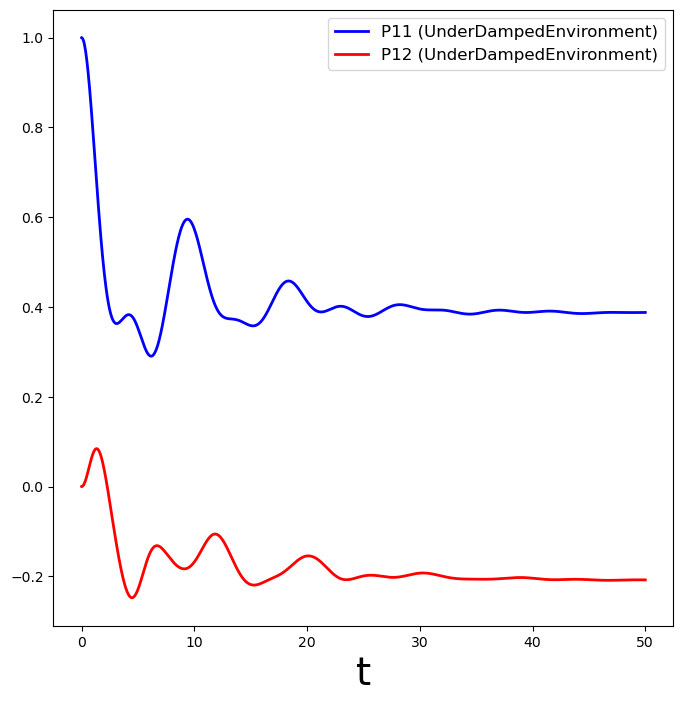

In [19]:
plot_result_expectations([
    (result_udbath, P11p, 'b', "P11 (UnderDampedEnvironment)"),
    (result_udbath, P12p, 'r', "P12 (UnderDampedEnvironment)"),
]);

The `UnderDampedEnvironment` class also allows us to easily evaluate analytical expressions for the power spectrum, correlation function, and spectral density. In the following plots, the solid lines are the exact expressions, and the dashed lines are based on our approximation of the correlation function with a finite number of exponents. In this case, there is an excellent agreement.

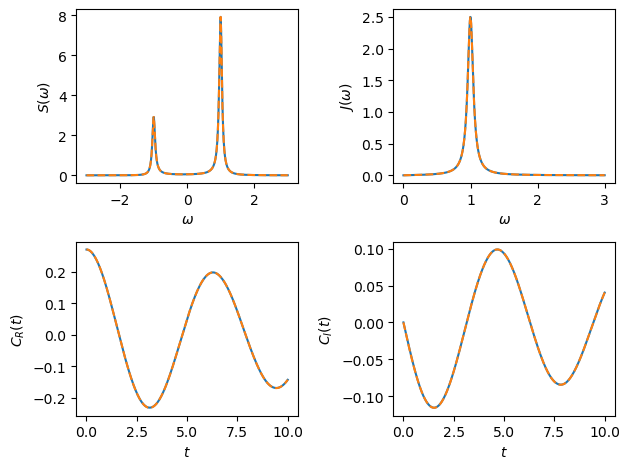

In [20]:
w = np.linspace(-3, 3, 1000)
w2 = np.linspace(0, 3, 1000)
t = np.linspace(0, 10, 1000)
env_cf = env.correlation_function(t)

fig, axs = plt.subplots(2, 2)

axs[0, 0].plot(w, env.power_spectrum(w))
axs[0, 0].plot(w, env_approx.power_spectrum(w), "--")
axs[0, 0].set(xlabel=r"$\omega$", ylabel=r"$S(\omega)$")
axs[0, 1].plot(w2, env.spectral_density(w2))
axs[0, 1].plot(w2, env_approx.spectral_density(w2), "--")
axs[0, 1].set(xlabel=r"$\omega$", ylabel=r"$J(\omega)$")
axs[1, 0].plot(t, np.real(env_cf))
axs[1, 0].plot(t, np.real(env_approx.correlation_function(t)), "--")
axs[1, 0].set(xlabel=r"$t$", ylabel=r"$C_{R}(t)$")
axs[1, 1].plot(t, np.imag(env_cf))
axs[1, 1].plot(t, np.imag(env_approx.correlation_function(t)), "--")
axs[1, 1].set(xlabel=r"$t$", ylabel=r"$C_{I}(t)$")

fig.tight_layout()
plt.show()

## Compare the results

### We can compare these results to those of the Bloch-Redfield solver in QuTiP:

In [21]:
with timer("ODE solver time"):
    resultBR = brmesolve(
        Hsys, rho0, tlist,
        a_ops=[[sigmaz(), env]], options=options,
    )

 [          0%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [          0%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [          0%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [          0%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.43s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.43s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.43s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.43s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.43s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.43s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.43s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.43s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.43s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.43s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.43s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.43s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.43s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.43s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.43s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.44s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.44s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.44s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.44s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.44s / Remaining 00:00:00:00

 [********100%***********] Elapsed 0.44s / Remaining 00:00:00:00

 [********100%***********] Elapsed 0.44s / Remaining 00:00:00:00

 [********100%***********] Elapsed 0.44s / Remaining 00:00:00:00

 [********100%***********] Elapsed 0.44s / Remaining 00:00:00:00

 [********100%***********] Elapsed 0.44s / Remaining 00:00:00:00

 Total run time:   0.44s
ODE solver time: 0.4422719478607178


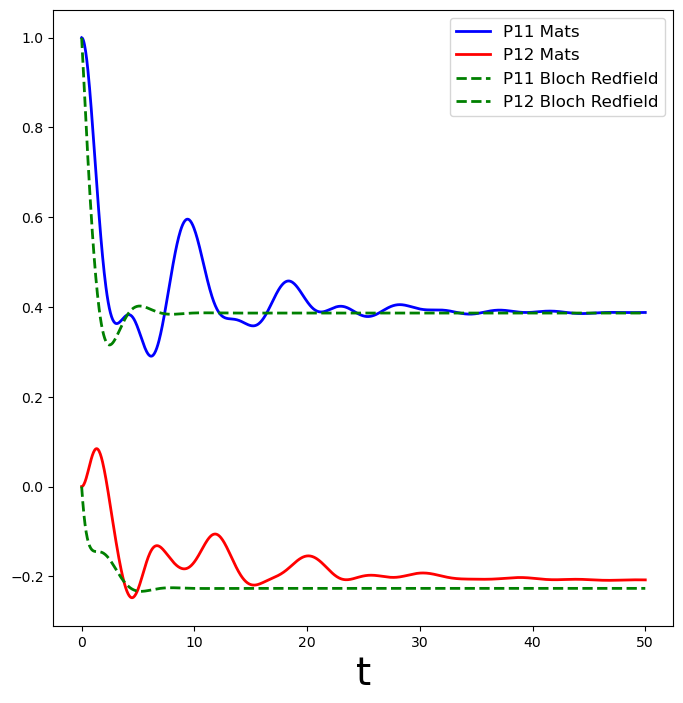

In [22]:
plot_result_expectations([
    (resultMats, P11p, 'b', "P11 Mats"),
    (resultMats, P12p, 'r', "P12 Mats"),
    (resultBR, P11p, 'g--', "P11 Bloch Redfield"),
    (resultBR, P12p, 'g--', "P12 Bloch Redfield"),
]);

### Lastly, let us calculate the analytical steady-state result and compare all of the results:

The thermal state of a reaction coordinate (treating the environment as a single damped mode) should, at high temperatures and small gamma, tell us the steady-state:

In [23]:
dot_energy, dot_state = Hsys.eigenstates()
deltaE = dot_energy[1] - dot_energy[0]

gamma2 = gamma
wa = w0  # reaction coordinate frequency
g = lam / np.sqrt(2 * wa)  # coupling

NRC = 10

Hsys_exp = tensor(qeye(NRC), Hsys)
Q_exp = tensor(qeye(NRC), Q)
a = tensor(destroy(NRC), qeye(2))

H0 = wa * a.dag() * a + Hsys_exp
# interaction
H1 = g * (a.dag() + a) * Q_exp

H = H0 + H1

energies, states = H.eigenstates()
rhoss = 0 * states[0] * states[0].dag()
for kk, energ in enumerate(energies):
    rhoss += states[kk] * states[kk].dag() * np.exp(-beta * energies[kk])
rhoss = rhoss / rhoss.norm()

P12RC = tensor(qeye(NRC), basis(2, 0) * basis(2, 1).dag())
P12RC = expect(rhoss, P12RC)

P11RC = tensor(qeye(NRC), basis(2, 0) * basis(2, 0).dag())
P11RC = expect(rhoss, P11RC)

In [24]:
rcParams = {
    "axes.titlesize": 25,
    "axes.labelsize": 30,
    "xtick.labelsize": 28,
    "ytick.labelsize": 28,
    "legend.fontsize": 28,
    "axes.grid": False,
    "savefig.bbox": "tight",
    "lines.markersize": 5,
    "font.family": "STIXgeneral",
    "mathtext.fontset": "stix",
    "font.serif": "STIX",
    "text.usetex": False,
}

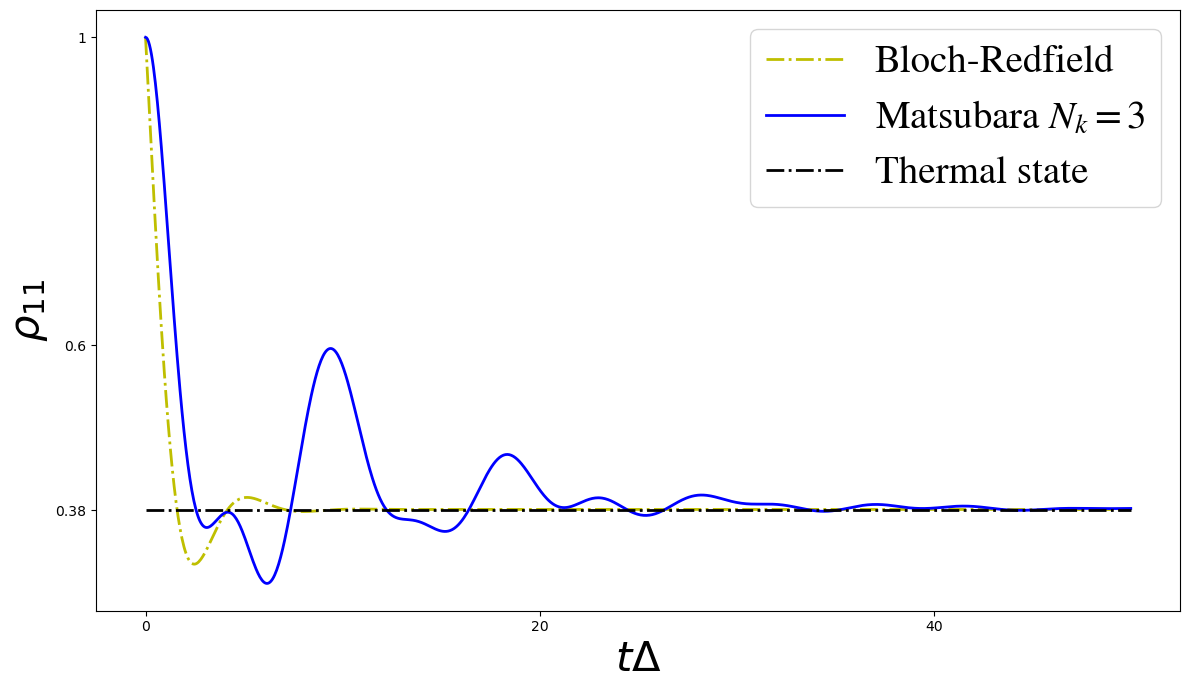

In [25]:
fig, axes = plt.subplots(1, 1, sharex=True, figsize=(12, 7))

with plt.rc_context(rcParams):
    plt.yticks([P11RC, 0.6, 1.0], [0.38, 0.6, 1])

    plot_result_expectations([
        (resultBR, P11p, 'y-.', "Bloch-Redfield"),
        (resultMats, P11p, 'b', "Matsubara $N_k=3$"),
    ], axes=axes)
    axes.plot(
        tlist, [P11RC for t in tlist],
        color='black', linestyle="-.", linewidth=2,
        label="Thermal state",
    )

    axes.set_xlabel(r'$t \Delta$', fontsize=30)
    axes.set_ylabel(r'$\rho_{11}$', fontsize=30)

    axes.locator_params(axis='y', nbins=4)
    axes.locator_params(axis='x', nbins=4)

    axes.legend(loc=0)

    fig.tight_layout()

## About

In [26]:
about()


QuTiP: Quantum Toolbox in Python
Copyright (c) QuTiP team 2011 and later.
Current admin team: Alexander Pitchford, Nathan Shammah, Shahnawaz Ahmed, Neill Lambert, Eric Giguère, Boxi Li, Simon Cross, Asier Galicia, Paul Menczel, and Patrick Hopf.
Board members: Daniel Burgarth, Robert Johansson, Anton F. Kockum, Franco Nori and Will Zeng.
Original developers: R. J. Johansson & P. D. Nation.
Previous lead developers: Chris Granade & A. Grimsmo.
Currently developed through wide collaboration. See https://github.com/qutip for details.

QuTiP Version:      5.3.0.dev0+6e4b53d
Numpy Version:      2.3.5
Scipy Version:      1.16.3
Cython Version:     3.2.2
Matplotlib Version: 3.10.8
Python Version:     3.12.0
Number of CPUs:     4
BLAS Info:          blas
INTEL MKL Ext:      None
Platform Info:      Linux (x86_64)
Installation path:  /home/runner/miniconda3/envs/test-environment-v5/lib/python3.12/site-packages/qutip

Installed QuTiP family packages
-------------------------------

qutip-qtrl: 

qutip-jax: 0.1.1.dev6
qutip-qip: 0.5.0.dev0+81a92b9

Please cite QuTiP in your publication.
For your convenience a bibtex reference can be easily generated using `qutip.cite()`


## Testing

This section can include some tests to verify that the expected outputs are generated within the notebook. We put this section at the end of the notebook, so it's not interfering with the user experience. Please, define the tests using assert, so that the cell execution fails if a wrong output is generated.

In [27]:
assert np.allclose(
    expect(P11p, resultMats.states[-100:]), P11RC, rtol=1e-2,
)
assert np.allclose(
    expect(P11p, resultBR.states[-100:]), P11RC, rtol=1e-2,
)